# Training machine learning algorithm to detect showers - preview of events

The goal of the method is to classify events into two categories - **shower**, **noise**

Main motivation behind the method was difficulty to formulate selection conditions by hand, although this was an initial plan behind applying feature extraction procedure on flight data. Defining simple manual rules and using them might still not be impossible. This is also motivation to use feature elimination methods to aid in formulating selection rules. Using decision tree-based methods for classification follows this line of thought. These methods include determining a feature importance and decision trees can be visualized to understand how is the decision being made.

This procedure consists of the following parts:
1. [Data selection](#Data-selection)
    - Visible simulated events (simu signal above the background, track recognized in simulated shower signal).
    - Noisy simulated events (triggered well outside of track injection GTU). However, the background noise is from the flight data.
    - Flight noise events (triggered well outside of GTU 40).
    - Flight classified events - classified by the manual classification.

## Imports
(section not in the report)

In [1]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
import traceback
import hashlib
import math
import collections
import functools

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

import tool.acqconv
from data_analysis_utils import *
from data_analysis_utils_dataframes import *
# import supervised_classification as supc    
from utility_funtions import key_vals2val_keys

Welcome to JupyROOT 6.13/02


In [3]:
import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.ensemble 
# import sklearn.neural_network
import sklearn.discriminant_analysis
import sklearn.model_selection
import sklearn.metrics
import sklearn.pipeline
from sklearn.externals import joblib

## Data selection

In [4]:
data_snippets_dir = 'ver4_machine_learning_w_labeled_flight_20190217'
os.makedirs(data_snippets_dir, exist_ok=True)
os.makedirs(os.path.join(data_snippets_dir, 'figures'), exist_ok=True)

In [5]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_simu = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_simu_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions_simu = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_simu)

In [6]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_flight = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions_flight = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_flight)

### Selected columns

Unlinke machine learning approach, that would be trained directly on pixels and learn to identify important features as a part of a learning (for example convolutional neural network), this approach depends on a set of preselected features. Its possible advantage is that there is no need to discover identified features and after the feature extraction, the training is faster.

One of the sources of possible bias in the analysis might be initial selection of features that are analyzed by feature elimination methods.

For this experiment selected features include:
- number of triggered pixels (`trg_count_nonzero`),
- some properties describing the background frames and background frames projection,
- similarly for all frames of an event
- informations about line orientations in projections of a shower
- informations about precision of estimation the orientation of a shower
- ...

In [7]:
common_included_columns_re_list = [
  ('^$','source_file_(acquisition|trigger)(_full)?|global_gtu|packet_id|gtu_in_packet|event_id|num_gtu'),
  ('^trg(_box_per_gtu|_pmt_per_gtu|_ec_per_gtu)?$', '^(count_nonzero|min|max|sum|mean)$'),
    
  ('^bg(_x_y)?$','^(mean_gz|mean|max|min|count_nonzero|sum|size)$'),
    
  ('^orig(_x_y)?$','^(count_nonzero|max|mean|mean_gz|sum|size)$'),

  '(proc\d|trg|alt\d)_(x|gtu)_(x|y)_hough_peak_thr[0-3]+_max_clu_major_line_(phi|rho)',
  '(proc\d|trg|alt\d)_(x|gtu)_(x|y)_hough_peak_thr[0-3]+_major_line_(phi|rho)',
  '(proc\d|trg|alt\d)_(x|gtu)_(x|y)_hough_peak_thr[0-3]+_line_clusters_((max_(peak|size|sum|area)_clu_(height|width|size))|count|sizes_max|clu_(widths|heights|areas)_max)',

  ('(proc\d|trg|alt\d)_(gtu|x)_[yx]_clusters',('^(count|sizes_max|sizes_min|clu_areas_max|max_(size|peak)_clu_(width|height|size))$')),  
  ('^proc\d_(x|gtu)_[yx]_hough_peak_thr3','major_line_coord_.*'),
    
]

#### List of columns of simu data tables used for analysis

In [8]:
common_columns_for_analysis_dict = query_functions_simu.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=common_included_columns_re_list
)

print_columns_dict(common_columns_for_analysis_dict)

spb_processing_v4_simu_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_simu_flatmap.event_trg_box_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_simu_flatmap.event_trg_pmt_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_simu_flatmap.event_trg_ec_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_simu_flatmap.event_trg_x_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_simu_flatmap.event_trg_gtu_x_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_simu_flatmap.event_trg_gtu_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_a

In [9]:
common_df_columns = query_functions_simu.get_dataframe_columns_from_dict(common_columns_for_analysis_dict)

#### List of columns of flight data tables used for analysis

In [10]:
flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=common_included_columns_re_list
)

print_columns_dict(flight_columns_for_analysis_dict)

spb_processing_v4_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_flatmap.event_trg_box_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_trg_pmt_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_trg_ec_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_trg_x_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_flatmap.event_trg_gtu_x_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_flatmap.event_trg_gtu_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- m

### Data selection queries

#### Simu visible events (base)

All positive samples for the training are simulated shower tracks with background from the flight data (see notebook ver4_flatmap_visible_events). Events considered as positive samples have to contain track signal (see ver4_test_selection_visualization__simu_signal notebook) and has to be considered as visible (see ver4_flatmap_simu_visible_events notebook). 

Visibility of the event is decided by a rule that **there should be at least two frames of the event which  contain a signal pixel that is greater or equal to maximum background intensity in the frame**.

Additionally there is rule that the first trigger of a visible event should be in GTU $42\pm10$.

In [11]:
# not in the report

current_columns_for_analysis_dict = common_columns_for_analysis_dict

common_select_clause_str, common_tables_list = \
    query_functions_simu.get_query_clauses__select(current_columns_for_analysis_dict)

simu_where_clauses_str, simu_tables_list = \
    query_functions_simu.get_query_clauses__where_simu(
        gtu_in_packet_distacne=(40, 10), 
        num_frames_signals_ge_bg__ge=2, num_frames_signals_ge_bg__le=999
    )

joined_select_clause_str = common_select_clause_str + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event.{}'.format(attr) for attr in [
        'simu2npy_pathname', 'edetector_numphotons', 'edetector_numcellhits', 'edetector_numfee', 'eptttrigger_fnumtrigg', 
        'etruth_trueenergy', 'etruth_truetheta', 'etruth_truephi', 'egeometry_pos_z'
    ]]) + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event_additional.{}'.format(attr) for attr in [
        'num_frames_counts_gt_bg', 'num_frames_signals_gt_bg', 'num_frames_signals_ge_bg'
    ]])

joined_tables_list = common_tables_list + simu_tables_list + [
    ('{database_schema_name}.simu_event_relation','{data_table_name}','event_id'),
    ('{database_schema_name}.simu_event_additional','{database_schema_name}.simu_event_relation','relation_id'),
    ('{database_schema_name}.simu_event','{database_schema_name}.simu_event_relation','simu_event_id'),
]

join_clauses_str = \
    query_functions_simu.get_query_clauses__join(joined_tables_list)

source_data_type_num = 3001

simu_events_selection_query = query_functions_simu.get_events_selection_query_plain(
    source_data_type_num=source_data_type_num,
    select_additional=joined_select_clause_str, 
    join_additional=join_clauses_str,
    where_additional=simu_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, 
    limit=350000,
    base_select='')

print(simu_events_selection_query)


    SELECT 
        
        spb_processing_v4_simu_flatmap.event.event_id, spb_processing_v4_simu_flatmap.event.source_file_acquisition_full, spb_processing_v4_simu_flatmap.event.source_file_trigger_full, spb_processing_v4_simu_flatmap.event.source_file_acquisition, spb_processing_v4_simu_flatmap.event.source_file_trigger, spb_processing_v4_simu_flatmap.event.global_gtu, spb_processing_v4_simu_flatmap.event.packet_id, spb_processing_v4_simu_flatmap.event.gtu_in_packet, spb_processing_v4_simu_flatmap.event.num_gtu, spb_processing_v4_simu_flatmap.event_trg_box_per_gtu.max AS trg_box_per_gtu_max, spb_processing_v4_simu_flatmap.event_trg_box_per_gtu.min AS trg_box_per_gtu_min, spb_processing_v4_simu_flatmap.event_trg_box_per_gtu.sum AS trg_box_per_gtu_sum, spb_processing_v4_simu_flatmap.event_trg_box_per_gtu.mean AS trg_box_per_gtu_mean, spb_processing_v4_simu_flatmap.event_trg_pmt_per_gtu.max AS trg_pmt_per_gtu_max, spb_processing_v4_simu_flatmap.event_trg_pmt_per_gtu.min AS trg_pmt_per

In [12]:
simu_df = psql.read_sql(simu_events_selection_query, event_v3_storage_provider_simu.connection)

In [13]:
simu_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,edetector_numcellhits,edetector_numfee,eptttrigger_fnumtrigg,etruth_trueenergy,etruth_truetheta,etruth_truephi,egeometry_pos_z,num_frames_counts_gt_bg,num_frames_signals_gt_bg,num_frames_signals_ge_bg
0,11464,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,17.0,...,0,29810,1,1.000000e+13,1.311530,2.02739,27000000.0,3.0,3.0,3.0
1,11465,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,163,1,35,24,17.0,...,0,35283,1,1.000000e+13,0.696797,4.65066,27000000.0,16.0,16.0,16.0
2,11486,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,22.0,...,0,29810,1,1.000000e+13,1.311530,2.02739,27000000.0,2.0,2.0,2.0
3,11487,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,20.0,...,0,29810,1,1.000000e+13,1.311530,2.02739,27000000.0,3.0,3.0,3.0
4,11494,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,166,1,38,10,1.0,...,0,40627,1,1.000000e+13,0.941292,5.61160,27000000.0,5.0,5.0,5.0


#### Simu noise events

Simu noise events are events that are caused by a trigger well outside of GTU of shower injection into a packet. 

It is not ideal to use these these events as samples of the dataset because due the way the background of these events is added to the signal. Simply, if there is less packets providing the background than simualated signal tracks then same event might be repeated multiple times in the dataset. 
Besides repetition of a background packet, background of the simualted event is created by repeating sequence of background frames, thus this might cause multiple events in a same packet. How often this situation happens has not been tested. It is not expected to be very typical.

Better method of constructing these events would help validity of this analysis.

In [14]:
# not in the report

current_columns_for_analysis_dict = common_columns_for_analysis_dict

common_select_clause_str, common_tables_list = \
    query_functions_simu.get_query_clauses__select(current_columns_for_analysis_dict)

# simu_noise_where_clauses_str = ' AND abs(gtu_in_packet-42) >= 20 '

# OPTIMIZATION, ROWS WITH NULL SHOULD BE ALSO ANALYZED 
simu_noise_where_clauses_str = '''
    AND abs(gtu_in_packet-42) >= 20 
    AND {database_schema_name}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {database_schema_name}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
    AND {database_schema_name}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
'''

joined_select_clause_str = common_select_clause_str + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event.{}'.format(attr) for attr in [
        'simu2npy_pathname', 'edetector_numphotons', 'edetector_numcellhits', 'edetector_numfee', 'eptttrigger_fnumtrigg', 
        'etruth_trueenergy', 'etruth_truetheta', 'etruth_truephi', 'egeometry_pos_z'
    ]]) + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event_additional.{}'.format(attr) for attr in [
        'num_frames_counts_gt_bg', 'num_frames_signals_gt_bg', 'num_frames_signals_ge_bg'
    ]])

joined_tables_list = common_tables_list + simu_tables_list + [
    ('{database_schema_name}.simu_event_relation','{data_table_name}','event_id'),
    ('{database_schema_name}.simu_event_additional','{database_schema_name}.simu_event_relation','relation_id'),
    ('{database_schema_name}.simu_event','{database_schema_name}.simu_event_relation','simu_event_id'),
]

join_clauses_str = \
    query_functions_simu.get_query_clauses__join(joined_tables_list)

source_data_type_num = 3001

noise_simu_events_selection_query = query_functions_simu.get_events_selection_query_plain(
    source_data_type_num=source_data_type_num,
    select_additional=joined_select_clause_str, 
    join_additional=join_clauses_str,
    where_additional=simu_noise_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, 
    limit=350000,
    base_select='')

print(noise_simu_events_selection_query)


    SELECT 
        
        spb_processing_v4_simu_flatmap.event.event_id, spb_processing_v4_simu_flatmap.event.source_file_acquisition_full, spb_processing_v4_simu_flatmap.event.source_file_trigger_full, spb_processing_v4_simu_flatmap.event.source_file_acquisition, spb_processing_v4_simu_flatmap.event.source_file_trigger, spb_processing_v4_simu_flatmap.event.global_gtu, spb_processing_v4_simu_flatmap.event.packet_id, spb_processing_v4_simu_flatmap.event.gtu_in_packet, spb_processing_v4_simu_flatmap.event.num_gtu, spb_processing_v4_simu_flatmap.event_trg_box_per_gtu.max AS trg_box_per_gtu_max, spb_processing_v4_simu_flatmap.event_trg_box_per_gtu.min AS trg_box_per_gtu_min, spb_processing_v4_simu_flatmap.event_trg_box_per_gtu.sum AS trg_box_per_gtu_sum, spb_processing_v4_simu_flatmap.event_trg_box_per_gtu.mean AS trg_box_per_gtu_mean, spb_processing_v4_simu_flatmap.event_trg_pmt_per_gtu.max AS trg_pmt_per_gtu_max, spb_processing_v4_simu_flatmap.event_trg_pmt_per_gtu.min AS trg_pmt_per

In [15]:
noise_simu_df = psql.read_sql(noise_simu_events_selection_query, event_v3_storage_provider_simu.connection)

In [16]:
noise_simu_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,edetector_numcellhits,edetector_numfee,eptttrigger_fnumtrigg,etruth_trueenergy,etruth_truetheta,etruth_truephi,egeometry_pos_z,num_frames_counts_gt_bg,num_frames_signals_gt_bg,num_frames_signals_ge_bg
0,11479,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,137,1,9,10,4.0,...,0,22456,0,1.000000e+13,0.765393,2.473790,27000000.0,NaN,NaN,NaN
1,11500,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,201,1,73,10,4.0,...,0,22456,0,1.000000e+13,0.765393,2.473790,27000000.0,NaN,NaN,NaN
2,11507,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,140,1,12,10,2.0,...,0,19291,0,1.000000e+13,1.192790,0.311703,27000000.0,NaN,NaN,NaN
3,11516,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,233,1,105,10,4.0,...,0,22456,0,1.000000e+13,0.765393,2.473790,27000000.0,NaN,NaN,NaN
4,11533,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,204,1,76,10,2.0,...,0,19291,0,1.000000e+13,1.192790,0.311703,27000000.0,NaN,NaN,NaN


#### Flight improbable events

More preferred set of background noise events consists of events that triggered outside of expected range of GTU. Note that these events were triggered in a configuration with lowered thresholds (number selected bin is halved). However, using such events on its own is not sufficient because the actual flight events are those that were triggered in default configuration.

In [17]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

unl_noise_flight_select_clause_str, unl_noise_flight_tables_list = \
    query_functions_flight.get_query_clauses__select(current_columns_for_analysis_dict)

unl_noise_flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(unl_noise_flight_tables_list)

unl_noise_source_data_type_num = 1

unl_noise_flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) > 20
    AND {database_schema_name}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {database_schema_name}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
    AND {database_schema_name}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
    AND {database_schema_name}.event_orig_x_y.count_nonzero > 256*6
''' 

unl_noise_flight_events_selection_query = \
    query_functions_flight.get_events_selection_query_plain(
        source_data_type_num=unl_noise_source_data_type_num,
        select_additional=unl_noise_flight_select_clause_str, 
        join_additional=unl_noise_flight_clauses_str,
        where_additional=unl_noise_flight_where_clauses_str,
        order_by='{data_table_name}.event_id', 
        offset=0, 
        limit=20000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
    #     limit=350000,
        base_select='')

print(unl_noise_flight_events_selection_query)


    SELECT 
        
        spb_processing_v4_flatmap.event.event_id, spb_processing_v4_flatmap.event.source_file_acquisition_full, spb_processing_v4_flatmap.event.source_file_trigger_full, spb_processing_v4_flatmap.event.source_file_acquisition, spb_processing_v4_flatmap.event.source_file_trigger, spb_processing_v4_flatmap.event.global_gtu, spb_processing_v4_flatmap.event.packet_id, spb_processing_v4_flatmap.event.gtu_in_packet, spb_processing_v4_flatmap.event.num_gtu, spb_processing_v4_flatmap.event_trg_box_per_gtu.max AS trg_box_per_gtu_max, spb_processing_v4_flatmap.event_trg_box_per_gtu.min AS trg_box_per_gtu_min, spb_processing_v4_flatmap.event_trg_box_per_gtu.sum AS trg_box_per_gtu_sum, spb_processing_v4_flatmap.event_trg_box_per_gtu.mean AS trg_box_per_gtu_mean, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.max AS trg_pmt_per_gtu_max, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.min AS trg_pmt_per_gtu_min, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.sum AS trg_pmt_pe

In [18]:
unl_noise_flight_df = psql.read_sql(unl_noise_flight_events_selection_query, event_v3_storage_provider_flight.connection)
# flight_df = psql.read_sql(flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [19]:
unl_noise_flight_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_size
0,63,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,94,0,94,12,1.0,...,3,9,3,9,3,9,3,5,5,5
1,65,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,131,1,3,12,2.0,...,9,15,9,15,9,15,9,18,18,18
2,94,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,479,3,95,10,2.0,...,4,11,4,11,4,11,4,7,7,7
3,97,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170502-061155...,trn_20170502-061155-001.001_C_inverse_flat_ave...,257,2,1,128,500.0,...,7,13,7,13,7,13,7,10,10,10
4,107,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170503-085415...,trn_20170503-085415-001.001_C_inverse_flat_ave...,119,0,119,13,2.0,...,6,20,6,20,6,2,1,6,2,6


#### Flight labeled events

Important part of the dataset is set of events that were triggered by the hardware. These events are expected to be the hardest to recognize. Previous classification experiments without this set of events significantly limited usefulness of the method because it classified 60% of the flight events sample as a track (see ver4_test_selection_visualization__simu_20181018 notebook).
Addition of a relatively small set of these events (around 1500) seems to help significantly (see ver4_machine_learning_flight_classification_tsne_cfg3 notebook).

The manually classified dataset has been created using web classification tool (script web_manual_classification.py). The tool is available at http://eusospb-data.michalvrabel.sk.

In [20]:
EVENT_CLASSES = {
    'dot': 2,
    'top_left_ec': 5,
    'blob': 12,
    'large_blob': 11,
    'short_single_gtu_track': 7,
    'single_gtu_track': 3,
    'noise': 1,
    'cartesian_line': 4,
    'strong_pmt_edge': 9,
    'few_dots': 6,
    'bg_increased_suddenly': 10,
    'persistent_dot': 14,
    'noise_unspecified': 0,
    'unspecified': 8,
    'shower': 13,
    '2pix_line': 15,
    'bright_blob': 16,
    'blob_and_dots': 17,
    'dot_w_blob_behind': 18,
    'storng_light': 19,
    'sparse_blobs': 20,
    'noise_with_week_dot': 21
}

EVENT_CLASS_NUMBER_UNLABELED = -1
EVENT_CLASS_NUMBER_UNLABELED_NOISE = -2
EVENT_CLASS_LABLELED_NOISE_FLIGHT = -3  # in case of reduced classification

classification_table_name = event_v3_storage_provider_flight.database_schema_name + '.event_manual_classification'
classification_table_cls_column_name_simple = 'class_number'
classification_table_note_column_name_simple = 'note'
classification_table_cls_column_name = classification_table_name + '.' + classification_table_cls_column_name_simple
classification_table_note_column_name = classification_table_name + '.' + classification_table_note_column_name_simple
classification_df_cls_column_name ='manual_classification_' + classification_table_cls_column_name_simple
classification_df_note_column_name ='manual_classification_' + classification_table_note_column_name_simple

In [21]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

lbl_noise_flight_select_clause_str, lbl_noise_flight_tables_list = \
    query_functions_flight.get_query_clauses__select({
        **current_columns_for_analysis_dict,
        classification_table_name: [classification_table_cls_column_name_simple]
    })

lbl_noise_flight_clauses_str = query_functions_flight.get_query_clauses__join(lbl_noise_flight_tables_list)

lbl_noise_source_data_type_num = 1

lbl_noise_flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) <= 20
    AND {{database_schema_name}}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {{database_schema_name}}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
    AND {{database_schema_name}}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
    AND {{database_schema_name}}.event_orig_x_y.count_nonzero > 256*6
    AND {classification_table_cls_column_name} NOT IN ({event_class_shower}, {event_class_unspecified})
'''.format(
    classification_table_cls_column_name=classification_table_cls_column_name,
    event_class_shower=EVENT_CLASSES['shower'],
    event_class_unspecified=EVENT_CLASSES['unspecified']
)
#TODO
lbl_noise_flight_events_selection_query = \
    query_functions_flight.get_events_selection_query_plain(
        source_data_type_num=lbl_noise_source_data_type_num,
        select_additional=lbl_noise_flight_select_clause_str, 
        join_additional=lbl_noise_flight_clauses_str,
        where_additional=lbl_noise_flight_where_clauses_str,
        order_by='{data_table_name}.event_id', 
        offset=0, 
        limit=10000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
    #     limit=350000,
        base_select='')

print(lbl_noise_flight_events_selection_query)


    SELECT 
        
        spb_processing_v4_flatmap.event.event_id, spb_processing_v4_flatmap.event.source_file_acquisition_full, spb_processing_v4_flatmap.event.source_file_trigger_full, spb_processing_v4_flatmap.event.source_file_acquisition, spb_processing_v4_flatmap.event.source_file_trigger, spb_processing_v4_flatmap.event.global_gtu, spb_processing_v4_flatmap.event.packet_id, spb_processing_v4_flatmap.event.gtu_in_packet, spb_processing_v4_flatmap.event.num_gtu, spb_processing_v4_flatmap.event_trg_box_per_gtu.max AS trg_box_per_gtu_max, spb_processing_v4_flatmap.event_trg_box_per_gtu.min AS trg_box_per_gtu_min, spb_processing_v4_flatmap.event_trg_box_per_gtu.sum AS trg_box_per_gtu_sum, spb_processing_v4_flatmap.event_trg_box_per_gtu.mean AS trg_box_per_gtu_mean, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.max AS trg_pmt_per_gtu_max, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.min AS trg_pmt_per_gtu_min, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.sum AS trg_pmt_pe

In [22]:
lbl_noise_flight_df = psql.read_sql(lbl_noise_flight_events_selection_query, event_v3_storage_provider_flight.connection)
# lbl_noise_flight_df[classification_df_cls_column_name] 

In [23]:
lbl_noise_flight_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_size,manual_classification_class_number
0,95,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,551,4,39,10,3.0,...,6,1,6,1,6,1,5,6,6,15
1,322,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170505-100211...,trn_20170505-100211-001.001_C_inverse_flat_ave...,547,4,35,10,9.0,...,3,3,3,3,3,3,4,4,4,3
2,520,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170505-100211...,trn_20170505-100211-001.001_C_inverse_flat_ave...,1576,12,40,10,15.0,...,8,3,8,3,8,3,8,8,8,12
3,548,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-004.001_C_inverse_flat_ave...,293,2,37,20,241.0,...,4,2,4,2,4,2,5,5,5,11
4,913,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055927...,trn_20170429-055927-001.001_C_inverse_flat_ave...,1959,15,39,20,141.0,...,18,2,18,2,18,2,16,16,16,19


#### Flight unclassified probable events

Small subset of flight unclassified events, that were caused by trigger around GTU 42, are selected to be used for basic check of the data reduction capability.

In [24]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

unl_flight_select_clause_str, unl_flight_tables_list = \
    query_functions_flight.get_query_clauses__select(current_columns_for_analysis_dict)

unl_flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(unl_flight_tables_list)

unl_flight_source_data_type_num = 1

unl_flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) < 20
    AND {{database_schema_name}}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {{database_schema_name}}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
    AND {{database_schema_name}}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
    AND {{database_schema_name}}.event_orig_x_y.count_nonzero > 256*6
    AND NOT EXISTS(
        SELECT {classification_table}.{{data_table_pk}} 
        FROM {classification_table} 
        WHERE {classification_table}.{{data_table_pk}} = {{data_table_name}}.{{data_table_pk}} LIMIT 1
    )
'''.format(
    classification_table=classification_table_name,
)

unl_flight_events_selection_query = query_functions_flight.get_events_selection_query_plain(
    source_data_type_num=unl_flight_source_data_type_num,
    select_additional=unl_flight_select_clause_str, 
    join_additional=unl_flight_clauses_str,
    where_additional=unl_flight_where_clauses_str,
    order_by='{data_table_name}.event_id',  # 'RANDOM()', # it might be skewed
    offset=0, 
    limit=10000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
#     limit=350000,
    base_select='')

print(unl_flight_events_selection_query)


    SELECT 
        
        spb_processing_v4_flatmap.event.event_id, spb_processing_v4_flatmap.event.source_file_acquisition_full, spb_processing_v4_flatmap.event.source_file_trigger_full, spb_processing_v4_flatmap.event.source_file_acquisition, spb_processing_v4_flatmap.event.source_file_trigger, spb_processing_v4_flatmap.event.global_gtu, spb_processing_v4_flatmap.event.packet_id, spb_processing_v4_flatmap.event.gtu_in_packet, spb_processing_v4_flatmap.event.num_gtu, spb_processing_v4_flatmap.event_trg_box_per_gtu.max AS trg_box_per_gtu_max, spb_processing_v4_flatmap.event_trg_box_per_gtu.min AS trg_box_per_gtu_min, spb_processing_v4_flatmap.event_trg_box_per_gtu.sum AS trg_box_per_gtu_sum, spb_processing_v4_flatmap.event_trg_box_per_gtu.mean AS trg_box_per_gtu_mean, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.max AS trg_pmt_per_gtu_max, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.min AS trg_pmt_per_gtu_min, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.sum AS trg_pmt_pe

In [25]:
unl_flight_df = psql.read_sql(unl_flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [26]:
unl_flight_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_size
0,61,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,39,0,39,11,7.0,...,2,6,2,6,2,6,2,5,5,5
1,67,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,166,1,38,11,7.0,...,3,8,3,8,3,8,3,8,8,8
2,73,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,39,0,39,22,7.0,...,7,4,2,4,2,4,2,3,4,4
3,75,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,162,1,34,15,526.0,...,3,3,3,3,3,3,3,4,4,4
4,77,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170430-072445...,trn_20170430-072445-001.001_C_inverse_flat_ave...,38,0,38,33,668.0,...,24,55,24,55,24,55,24,391,391,391


#### Classification column for unlabeled filght
(not in the report)

In [27]:
unl_flight_df[classification_df_cls_column_name] = EVENT_CLASS_NUMBER_UNLABELED
unl_noise_flight_df[classification_df_cls_column_name] = EVENT_CLASS_NUMBER_UNLABELED_NOISE

### Flight datasets in dict
(not in the report)

In [28]:
flight_df_dict = {
    'unl_noise_flight_df': unl_noise_flight_df, 
    'lbl_noise_flight_df': lbl_noise_flight_df, 
    'unl_flight_df': unl_flight_df
}

### Closing connections
(not in the report)

In [29]:
event_v3_storage_provider_simu.connection.close()
event_v3_storage_provider_flight.connection.close()

### Combined simulations dataset

Simu dataframes are combined because they have same columns. 
Then within this dataset events are classified into four groups based on 
- **Query classification information** - Primary classification based on the original data selection query - original intention of the data selection.
- **Simu signal classification information** - Secondary classification is addition of labeled simu signal events. The events are loaded from tables prepared in ver4_test_selection_visualization__simu_signal notebook.

The groups are the following:
- **simu noise** - data selected by query intended to select visible events but simu signal is classified as noisy simu data
- **simu track** - data selected by query intended to select visible events and simu signal is classified as a signal - <br> *these events will be used as positive samples for machine learning algorithms*
- **noise track** - data selected by query intended to select noise events but simu signal is classified as a shower
- **noise noise** - data selected by query intended to select noise events and contains simu signal classified as noisy simu data (could be used as a part of negative samples dataset, although it is not ideal)
- **simu unclassified**, **noise unclassified** - data without any labelling for simu signal data, generaly should consist of short tracks or noisy tracks, in-between easily recognizable tracks and noise.
- **simu noise underflow**, **simu noise overflow**, **simu track underflow**, **simu track overflow** - data selected by query intended to select visible events but no simu signal is present (ideally should be empty)
- **noise noise underflow**, **noise noise overflow**, **noise track underflow**, **noise track overflow**   - data selected by query intended to select noise events and no simu signal is present - <br> *these events will be used as negative samples but with a low priority*

In [30]:
combined_simu_df = pd.concat([simu_df, noise_simu_df])

In [31]:
# flight_columns_list = list(lbl_noise_flight_df.columns.values)
# combined_flight_df = pd.concat([unl_noise_flight_df[flight_columns_list], lbl_noise_flight_df[flight_columns_list], unl_flight_df[flight_columns_list]])

In [32]:
print('len(simu_df) =', len(simu_df))
print('len(noise_simu_df) =', len(noise_simu_df))
print('len(combined_simu_df) =', len(combined_simu_df))

len(simu_df) = 35607
len(noise_simu_df) = 128793
len(combined_simu_df) = 164400


#### Query classification information
Primary classification based on the original data selection query - original intention of the data selection.

In [33]:
combined_simu_df['cond_selection_query'] = 'undefined'
combined_simu_df.loc[combined_simu_df['event_id'].isin(simu_df['event_id']), 'cond_selection_query'] = 'simu'
combined_simu_df.loc[combined_simu_df['event_id'].isin(noise_simu_df['event_id']), 'cond_selection_query'] = 'noise'

In [34]:
if('simu_df' in locals()): del simu_df
if('noise_simu_df' in locals()): del noise_simu_df
# if('unl_noise_flight_df' in locals()): del unl_noise_flight_df
# if('lbl_noise_flight_df' in locals()): del lbl_noise_flight_df
# if('unl_flight_df' in locals()): del unl_flight_df

#### Simu signal classification information
Secondary classification is addition of labeled simu signal events.
The events are loaded from tables prepared in ver4_test_selection_visualization__simu_signal notebook.

In [35]:
# [['event_id', 'source_file_acquisition', 'global_gtu', 'packet_id', 'gtu_in_packet', 'num_gtu', 'source_file_acquisition_full']]

simu_signal_data_snippets_dir = 'ver4_simu_signal_data_snippets'
simu_signal_visible_tracks_table_path = os.path.join(simu_signal_data_snippets_dir, 'visible_tracks_table.tsv')
simu_signal_noisy_events_table_path = os.path.join(simu_signal_data_snippets_dir, 'noisy_events_table.tsv')

combined_simu_df, unclassified_simu_df, \
track_simu_df, track_underflow_simu_df, track_overflow_simu_df, \
noise_simu_df, noise_underflow_simu_df, noise_overflow_simu_df, \
simu_signal_track_events_df, simu_signal_noisy_events_df = \
    add_classification_columns(
        combined_simu_df, 
        simu_signal_visible_tracks_table_path, simu_signal_noisy_events_table_path,
        ret_simu_signal=True, ret_under_over_track=True, ret_split_noise=True,
        simu_track_class='track', simu_noise_class='noise',
        simu_track_underflow_class='track_underflow', simu_track_overflow_class='track_overflow',
        simu_noise_underflow_class='noise_underflow', simu_noise_overflow_class='noise_overflow',
        simu_events_file_pathname_dir=data_snippets_dir)

##### Combined label - joining query and labeled simu class

In [36]:
combined_simu_df['cond_selection_combined'] = 'undefined'

for selection_query in ['simu','noise']:
    for selection_simu_signal in ['noise','track']:
        for simu_signal_sync in ['', 'underflow', 'overflow']:
            t_selection_simu_signal = selection_simu_signal
            if len(simu_signal_sync) > 0:
                t_selection_simu_signal += '_' + simu_signal_sync
            combined_simu_df.loc[
                (combined_simu_df['cond_selection_query'] == selection_query ) & 
                (combined_simu_df['cond_selection_simple'] == t_selection_simu_signal), 
                'cond_selection_combined'] = selection_query + '_' + t_selection_simu_signal

##### Size of the  subsets

###### Simu signal labels

In [37]:
print('len(simu_signal_track_events_df)', len(simu_signal_track_events_df))
print('len(simu_signal_noisy_events_df)', len(simu_signal_noisy_events_df))
print('-'*50)
print('len(combined_simu_df)           ', len(combined_simu_df))
print('-'*50)
print('len(unclassified_simu_df)       ', len(unclassified_simu_df))
print('len(track_simu_df)              ', len(track_simu_df))
print('len(track_underflow_simu_df)    ', len(track_underflow_simu_df))
print('len(track_overflow_simu_df)     ', len(track_overflow_simu_df))
print('len(noise_simu_df)              ', len(noise_simu_df))
print('len(noise_underflow_simu_df)    ', len(noise_underflow_simu_df))
print('len(noise_overflow_simu_df)     ', len(noise_overflow_simu_df))
print('-'*50)
print('                                   ', 
      len(unclassified_simu_df) + \
      len(track_simu_df) + len(track_underflow_simu_df) + len(track_overflow_simu_df) + \
      len(noise_simu_df) + len(noise_underflow_simu_df) + len(noise_overflow_simu_df)
     )
print('-'*50)
print('len(track_simu_df)/len(combined_simu_df)        = ', len(track_simu_df)/len(combined_simu_df))
print('len(unclassified_simu_df)/len(combined_simu_df) = ', len(unclassified_simu_df)/len(combined_simu_df))
print('len(noise_simu_df)/len(combined_simu_df)        = ', len(noise_simu_df)/len(combined_simu_df))

len(simu_signal_track_events_df) 14866
len(simu_signal_noisy_events_df) 59279
--------------------------------------------------
len(combined_simu_df)            164400
--------------------------------------------------
len(unclassified_simu_df)        9288
len(track_simu_df)               35038
len(track_underflow_simu_df)     5983
len(track_overflow_simu_df)      16956
len(noise_simu_df)               1608
len(noise_underflow_simu_df)     24689
len(noise_overflow_simu_df)      70838
--------------------------------------------------
                                    164400
--------------------------------------------------
len(track_simu_df)/len(combined_simu_df)        =  0.2131265206812652
len(unclassified_simu_df)/len(combined_simu_df) =  0.056496350364963505
len(noise_simu_df)/len(combined_simu_df)        =  0.00978102189781022


###### Selection query and simu signal labels

In [38]:
for selection_query in ['simu','noise']:
    for selection_simu_signal in ['noise','track']:
        for simu_signal_sync in ['', 'underflow', 'overflow']:
            t_selection_simu_signal = selection_simu_signal
            if len(simu_signal_sync) > 0:
                t_selection_simu_signal += '_' + simu_signal_sync
            print('{:<30} {}'.format(
                '{} - {}'.format(selection_query, t_selection_simu_signal),
                np.count_nonzero(
                    (combined_simu_df['cond_selection_query'] == selection_query ) & \
                    (combined_simu_df['cond_selection_simple'] == t_selection_simu_signal))
            ))                

simu - noise                   4
simu - noise_underflow         0
simu - noise_overflow          0
simu - track                   34521
simu - track_underflow         0
simu - track_overflow          0
noise - noise                  1604
noise - noise_underflow        24689
noise - noise_overflow         70838
noise - track                  517
noise - track_underflow        5983
noise - track_overflow         16956


##### Example of track underflow subset

In [39]:
track_underflow_simu_df.sort_values('gtu_in_packet', ascending=False).head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,etruth_truetheta,etruth_truephi,egeometry_pos_z,num_frames_counts_gt_bg,num_frames_signals_gt_bg,num_frames_signals_ge_bg,cond_selection_query,simu2npy_signals_pathname,simu2npy_signals_pathname_short,cond_selection_simple
45187,2109098,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_21000000.00/energy_1.41e+12/thousnd21E3.2...,posz_21000000.00/energy_1.41e+12/thousnd21E3.2...,150,1,22,11,2.0,...,0.204112,5.167210,21000000.0,NaN,NaN,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_21000000.00/energy_1.41e+12/thousnd21E3.2...,track_underflow
25116,189885,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_24000000.00/energy_5.95e+12/simu.2017-07-...,posz_24000000.00/energy_5.95e+12/simu.2017-07-...,150,1,22,10,2.0,...,1.409600,0.066001,24000000.0,NaN,NaN,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_24000000.00/energy_5.95e+12/simu.2017-07-...,track_underflow
21799,154316,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_24000000.00/energy_5.95e+12/simu.2017-07-...,posz_24000000.00/energy_5.95e+12/simu.2017-07-...,150,1,22,9,2.0,...,1.210180,4.709430,24000000.0,NaN,NaN,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_24000000.00/energy_5.95e+12/simu.2017-07-...,track_underflow
3711,36818,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.26e+12/thousnd27E2/n...,posz_27000000.00/energy_1.26e+12/thousnd27E2/l...,150,1,22,10,4.0,...,0.863273,2.466220,27000000.0,NaN,NaN,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_27000000.00/energy_1.26e+12/thousnd27E2/s...,track_underflow
93171,2411359,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_18000000.00/energy_5.25e+12/simu.2017-07-...,posz_18000000.00/energy_5.25e+12/simu.2017-07-...,150,1,22,10,4.0,...,0.267307,3.613280,18000000.0,NaN,NaN,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_18000000.00/energy_5.25e+12/simu.2017-07-...,track_underflow


##### Example of track overflow subset

In [40]:
track_overflow_simu_df.sort_values('gtu_in_packet', ascending=True).head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,etruth_truetheta,etruth_truephi,egeometry_pos_z,num_frames_counts_gt_bg,num_frames_signals_gt_bg,num_frames_signals_ge_bg,cond_selection_query,simu2npy_signals_pathname,simu2npy_signals_pathname_short,cond_selection_simple
53058,2156392,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_30000000.00/energy_2.00e+12/thousnd30E6.2...,posz_30000000.00/energy_2.00e+12/thousnd30E6.2...,190,1,62,20,15.0,...,1.023690,6.275790,30000000.0,NaN,NaN,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_30000000.00/energy_2.00e+12/thousnd30E6.2...,track_overflow
58199,2189735,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_30000000.00/energy_1.58e+12/thousnd30E4.2...,posz_30000000.00/energy_1.58e+12/thousnd30E4.2...,190,1,62,10,2.0,...,1.156900,1.471500,30000000.0,NaN,NaN,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_30000000.00/energy_1.58e+12/thousnd30E4.2...,track_overflow
58697,2192502,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_30000000.00/energy_1.58e+12/thousnd30E4.2...,posz_30000000.00/energy_1.58e+12/thousnd30E4.2...,190,1,62,14,5.0,...,0.914056,0.401451,30000000.0,NaN,NaN,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_30000000.00/energy_1.58e+12/thousnd30E4.2...,track_overflow
59486,2196758,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_21000000.00/energy_3.94e+12/ter212.2017-0...,posz_21000000.00/energy_3.94e+12/ter212.2017-0...,190,1,62,12,1.0,...,1.371050,1.387970,21000000.0,NaN,NaN,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_21000000.00/energy_3.94e+12/ter212.2017-0...,track_overflow
110238,2510779,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_18000000.00/energy_8.50e+12/set18.2017-07...,posz_18000000.00/energy_8.50e+12/set18.2017-07...,190,1,62,14,5.0,...,0.940455,5.381020,18000000.0,0.0,0.0,0.0,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_18000000.00/energy_8.50e+12/set18.2017-07...,track_overflow


##### Visualization of a few events

- Noise entries are sorted by number of simu signal pixles in x-y projection in descending order (`orig_x_y_count_nonzero`, sorted from the most potentially track-like),
- Track entries are sorted by num frames where maximum signal is greater equal maximum background in acsending order (`num_frames_signals_ge_bg`, from the least visible track events). Non-track-like simu signal might not be necessarly incorrectly labeled entries, just a small portion of a track in signal.
- Track underflow, track overflow should all contain empty simu signal data. Entries are sorted by GTU in packet in ascending or descending order, respectively.

In [67]:
def vis_simu_signal_default(i, r, visualized_projections, fig, axs_flattened): 
    show_simu_event_row(i, r, 
        npy_pathname_column='simu2npy_signals_pathname', 
        single_proj_width=4, single_proj_height=3,
        print_info=False, warn_if_not_exact_simu=False)

def vis_simu_signal_with_original(i, r, visualized_projections, fig, axs_flattened):
    vis_simu_signal_default(i, r, visualized_projections, fig, axs_flattened)
    show_simu_event_row(i, r, 
        npy_pathname_column='simu2npy_signals_pathname', 
        single_proj_width=4, single_proj_height=3,
        print_info=False, warn_if_not_exact_simu=False,
        simu_gtu_override=(30,50))

for label, events_to_vis_df in [
        ('noise', noise_simu_df.sort_values('orig_x_y_count_nonzero', ascending=False)), 
        ('track', track_simu_df.sort_values('num_frames_signals_ge_bg', ascending=True)), 
        ('track_underflow', track_underflow_simu_df.sort_values('gtu_in_packet', ascending=False)), 
        ('track_overflow', track_overflow_simu_df.sort_values('gtu_in_packet', ascending=True))
]:
    print('{} ({} entries)'.format(label, len(events_to_vis_df)))
    print('-' * 50)
    vis_events_df(
        events_to_vis_df, 
        events_per_figure=3, max_figures=1, vis_gtux=True, vis_gtuy=True, 
        close_after_vis=False, show=True, 
        additional_printed_columns=[
            'num_frames_signals_ge_bg', 'simu2npy_signals_pathname_short', 
            'cond_selection_query', 'cond_selection_simple'],
        by_one=True,
        extension_func=vis_simu_signal_with_original if label == 'track' else vis_simu_signal_default,
        single_proj_width=4, single_proj_height=3
    )
    print('=' * 50)

NameError: name 'track_simu_df' is not defined

### Adding new features

#### Rank column
The principle of a rank column is to combine values of features based on expected or calculated correlation of a column with likeliness of an event being a shower. The lowest value should correspond to the most probable shower track.

In this case, a short set of hand-picked list is utilized. More preferable way of doing this would be to use columns selected by a machine learning approach that calculates feature importance.

The provided features are normalized to 0-1 range, 
optionally, the values of the features are inverted (1-val) and weighted. 
Finally, the summed value is resulting rank of a record.

In [42]:
rank_columns = ['proc1_x_y_hough_peak_thr2_line_clusters_count', 'proc1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 
                 'proc1_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 'proc1_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width',
                 'trg_count_nonzero', 'num_gtu']

def add_rank_column_default(data_df):
    add_rank_column(data_df, 
                    rank_columns, 
                    ascending=[True, True, True, True, False, False], 
                    column_weights=[2,2,1,1,1,1],
                    print_max_vals=True, add_norm_columns=True, do_copy=False)

#### Difference columns
Expected property of air shower event is that at least in one of the shower projections in time should contain a line with a slope different than 0 or 90 degrees. 
In an ideal case an actual slope of a line is not important, only important information is slope difference to 0 or 90 degrees.

In [43]:
# not in the report
area_columns_prefix_list = ('proc1', 'proc2', 'proc3', 'trg')
area_columns_proj_list = ('x_y', 'gtu_x', 'gtu_y')
area_columns_thr_i_list = list(range(1,4))

area_columns_line_types = ['peak', 'sum', 'size']
area_columns_col_name_prefixes = ['{{prefix}}_{{proj}}_hough_peak_thr{{thr_i}}_line_clusters_max_{}_clu_'.format(t) for t in area_columns_line_types]

diff_columns_proc_range = (1,4)
diff_columns_alt_range = (1,1)
diff_columns_thr_range = (1,4)

diff_columns_prefixes = \
    ['proc{}'.format(i) for i in range(*diff_columns_proc_range)] + \
    ['alt{}'.format(i) for i in range(*diff_columns_alt_range)]

diff_columns_projs = ['gtu_x', 'gtu_y']
diff_columns_diff_types = ['pi_over_2', '0']

diff_columns_gtu_y_gtu_x_diff_format = '{prefix}_gtu_y_gtu_x_hough_peak_thr{thr_i}_major_line_phi_diff'
diff_columns_proj_diff_format = '{prefix}_{proj}_hough_peak_thr{thr_i}_major_line_phi_diff_{diff_type}'

#

common_extension_columns = ['event_id', 'rank']

for col in rank_columns:
    common_extension_columns.append('norm_' + col)

for prefix in area_columns_prefix_list:
    for proj in area_columns_proj_list:
        for thr_i in area_columns_thr_i_list:
            for col_name_prefix in area_columns_col_name_prefixes:
                common_extension_columns.append(col_name_prefix.format(prefix=prefix, proj=proj, thr_i=thr_i) + 'area')
    
for prefix in diff_columns_prefixes:
    for thr_i in range(*diff_columns_thr_range):
        common_extension_columns.append(diff_columns_gtu_y_gtu_x_diff_format.format(prefix=prefix, thr_i=thr_i))
        for proj in diff_columns_projs:
            for diff_type in diff_columns_diff_types:
                common_extension_columns.append(diff_columns_proj_diff_format.format(prefix=prefix, thr_i=thr_i, proj=proj, diff_type=diff_type))


simu_extension_columns = common_extension_columns
flight_extension_columns = common_extension_columns

# print(common_extension_columns)

#### Simu dataframe extension columns
(not in the report)

In [44]:
simu_event_ids_md5 = hashlib.md5(pickle.dumps(combined_simu_df['event_id'].values, protocol=0)).hexdigest()
simu_extension_columns_md5 = hashlib.md5(','.join(simu_extension_columns).encode()).hexdigest()
extension_columns_combined_simu_pathname = os.path.join(data_snippets_dir, 'extension_columns_simu_pathname_{}_{}.pkl.gz'.format(simu_event_ids_md5, simu_extension_columns_md5))
print(extension_columns_combined_simu_pathname)

ver4_machine_learning_w_labeled_flight_20190217/extension_columns_simu_pathname_771a6a452a651f419ec12b94ac5eb28d_51d1629013c22c624c6bcb50d5b214a0.pkl.gz


In [45]:
if not os.path.exists(extension_columns_combined_simu_pathname):
    print('Building calculating columns ...')
    print('num_frames_signals_ge_bg bin column ...')
    
    add_bin_column(combined_simu_df, 'num_frames_signals_ge_bg', 5)

    print('  area columns ...')
    
    for attr_prefix_format in area_columns_col_name_prefixes:    
        add_area_columns(combined_simu_df, prefix_list=area_columns_prefix_list, proj_list=area_columns_proj_list, thr_i_list=area_columns_thr_i_list,
                        attr_prefix_format=attr_prefix_format) 

    print('  diff columns ...')
    
    add_diff_columns(combined_simu_df, proc_range=diff_columns_proc_range, alt_range=diff_columns_alt_range, hough_peak_thr_range=diff_columns_thr_range)

    print('  rank column ...')
    
    add_rank_column_default(combined_simu_df)

    print('Saving pickle ...')
        
    combined_simu_df[simu_extension_columns].to_pickle(extension_columns_combined_simu_pathname, 'gzip')
    
else:
    print('Loading...')
    simu_extension_columns_df = pd.read_pickle(extension_columns_combined_simu_pathname, 'gzip')
    print('Merging ...')
    combined_simu_df = pd.merge(combined_simu_df, simu_extension_columns_df, on=['event_id'])
    del simu_extension_columns_df
    
combined_simu_df.head()

Loading...
Merging ...


,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,proc3_gtu_y_gtu_x_hough_peak_thr2_major_line_phi_diff,proc3_gtu_x_hough_peak_thr2_major_line_phi_diff_pi_over_2,proc3_gtu_x_hough_peak_thr2_major_line_phi_diff_0,proc3_gtu_y_hough_peak_thr2_major_line_phi_diff_pi_over_2,proc3_gtu_y_hough_peak_thr2_major_line_phi_diff_0,proc3_gtu_y_gtu_x_hough_peak_thr3_major_line_phi_diff,proc3_gtu_x_hough_peak_thr3_major_line_phi_diff_pi_over_2,proc3_gtu_x_hough_peak_thr3_major_line_phi_diff_0,proc3_gtu_y_hough_peak_thr3_major_line_phi_diff_pi_over_2,proc3_gtu_y_hough_peak_thr3_major_line_phi_diff_0
0,11464,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,17.0,...,0.369017,1.271984,0.298812,1.500591,0.070205,0.386129,1.254872,0.315924,1.500591,0.070205
1,11465,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,163,1,35,24,17.0,...,1.226577,0.029304,1.541493,1.255881,0.314915,1.219437,0.052804,1.517993,1.272241,0.298555
2,11486,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,22.0,...,0.184444,1.210844,0.359952,1.395288,0.175508,0.184444,1.210844,0.359952,1.395288,0.175508
3,11487,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,20.0,...,0.182697,1.315778,0.255018,1.498476,0.072321,0.272988,1.255128,0.315668,1.528116,0.042680
4,11494,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,166,1,38,10,1.0,...,0.075040,1.338344,0.232453,1.263304,0.307493,0.090020,1.354184,0.216613,1.264164,0.306633


#### Flight dataframe extension columns
(not in the report)

In [46]:
# if('unl_noise_flight_df' in locals()): del unl_noise_flight_df
# if('lbl_noise_flight_df' in locals()): del lbl_noise_flight_df
# if('unl_flight_df' in locals()): del unl_flight_df

extension_columns_flight_pathnames = {}

for subset_label, subset_df in \
        flight_df_dict.items():
    flight_event_ids_md5 = hashlib.md5(pickle.dumps(subset_df['event_id'].values, protocol=0)).hexdigest()
    flight_extension_columns_md5 = hashlib.md5(','.join(flight_extension_columns).encode()).hexdigest()
    extension_columns_flight_pathnames[subset_label] = \
        os.path.join(data_snippets_dir, 
                     'extension_columns_{}_{}_{}.pkl.gz'.format(
                         subset_label,
                         flight_event_ids_md5, flight_extension_columns_md5))
    print(extension_columns_flight_pathnames[subset_label])  
    
# flight_event_ids_md5 = hashlib.md5(pickle.dumps(combined_flight_df['event_id'].values, protocol=0)).hexdigest()
# flight_extension_columns_md5 = hashlib.md5(','.join(flight_extension_columns).encode()).hexdigest()
# extension_columns_flight_pathname = os.path.join(data_snippets_dir, 'extension_columns_flight_pathname_{}_{}.pkl.gz'.format(flight_event_ids_md5, flight_extension_columns_md5))
# print(extension_columns_flight_pathname)

ver4_machine_learning_w_labeled_flight_20190217/extension_columns_unl_noise_flight_df_5c5e8cceb8fcfa9c5e4874b6127400ac_51d1629013c22c624c6bcb50d5b214a0.pkl.gz
ver4_machine_learning_w_labeled_flight_20190217/extension_columns_lbl_noise_flight_df_e2f3f928212d45ae6c6063bf71aeec0f_51d1629013c22c624c6bcb50d5b214a0.pkl.gz
ver4_machine_learning_w_labeled_flight_20190217/extension_columns_unl_flight_df_3b6a364256ef79211bd904397926b2af_51d1629013c22c624c6bcb50d5b214a0.pkl.gz


In [47]:
for subset_label, extension_columns_flight_pathname in extension_columns_flight_pathnames.items():
    if not os.path.exists(extension_columns_flight_pathname):
        subset_df = flight_df_dict[subset_label]
        
        print('  Building calculating columns ...')

        print('    area columns ...')

        for attr_prefix_format in area_columns_col_name_prefixes:    
            add_area_columns(subset_df, prefix_list=area_columns_prefix_list, proj_list=area_columns_proj_list, thr_i_list=area_columns_thr_i_list,
                            attr_prefix_format=attr_prefix_format) 

        print('    diff columns ...')

        add_diff_columns(subset_df, proc_range=diff_columns_proc_range, alt_range=diff_columns_alt_range, hough_peak_thr_range=diff_columns_thr_range)

        print('    rank column ...')

        add_rank_column_default(subset_df)

        print('  Saving pickle ...')

        subset_df[flight_extension_columns].to_pickle(extension_columns_flight_pathname, 'gzip')

    else:
        print('  Loading ...')
        flight_extension_columns_df = pd.read_pickle(extension_columns_flight_pathname, 'gzip')
        print('  Merging ...')
        flight_df_dict[subset_label] = pd.merge(flight_df_dict[subset_label], flight_extension_columns_df, on=['event_id'])
        del flight_extension_columns_df
    
#     flight_df_dict[subset_label].head()

  Loading ...
  Merging ...
  Loading ...
  Merging ...
  Loading ...
  Merging ...


### Number of NaN entries
Events with NaN values in are currently rejected from showers dataset. 
However, final decision about rejection is made considering only columns using in ML algorithm.
Therefore, these numbers are not exactly indicative of the the final number of rejected events - only simu_track and noise_track should be indicative. (TODO requires check)

#### Number of NaN entries by query and simu signal labels

In [48]:
print('{:<30} {:<10} {}'.format(' ', 'NaN', 'Others'))
for selection_query in ['simu','noise']:
    for selection_simu_signal in ['noise','track']:
        for simu_signal_sync in ['', 'underflow', 'overflow']:
            t_selection_simu_signal = selection_simu_signal
            if len(simu_signal_sync) > 0:
                t_selection_simu_signal += '_' + simu_signal_sync
            subset_df = combined_simu_df[
                (combined_simu_df['cond_selection_query'] == selection_query ) & 
                (combined_simu_df['cond_selection_simple'] == t_selection_simu_signal)
            ]
            nan_row_count = np.count_nonzero(subset_df.isnull().any(axis=1))
            print('{:<30} {:<10} {}'.format(
                '{} - {}'.format(selection_query, t_selection_simu_signal),
                nan_row_count, len(subset_df) - nan_row_count
            ))

                               NaN        Others
simu - noise                   2          2
simu - noise_underflow         0          0
simu - noise_overflow          0          0
simu - track                   2699       31822
simu - track_underflow         0          0
simu - track_overflow          0          0
noise - noise                  4          1600
noise - noise_underflow        24401      288
noise - noise_overflow         69387      1451
noise - track                  1          516
noise - track_underflow        5911       72
noise - track_overflow         16514      442


Flight data were already selected excluding entries with NaN values (actually NULL in PostgreSQL table).

In [49]:
for subset_label, subset_df in flight_df_dict.items():
    print('{:50}: {:d}'.format(subset_label, np.count_nonzero(subset_df.isnull().any(axis=1))))

unl_noise_flight_df                               : 0
lbl_noise_flight_df                               : 0
unl_flight_df                                     : 0


#### NaN columns
Columns with a NaN value are either data from Hough transform on projections of triggered pixels - issue is a single pixel in a projection, thus it is impossible to determine orientation of a line. This impacts usable size of the dataset.
Other source of NaN values are additional information calculated for simulated shower - it is number of frames where number of signal pixels satisfies certain condition. The NaN value is present when there are no signal present in an identified event.

In [50]:
# nan_columns = {}

# for i, r in combined_simu_df[combined_simu_df.isnull().any(axis=1)].iterrows():
#     for col, val in r.iteritems():
#         if isinstance(val, numbers_Number) and math.isnan(val):
#             if col not in nan_columns:
#                 nan_columns[col] = 0
#             nan_columns[col] += 1

# for col, val in nan_columns.items():
#     print("{:<120} : {:<d}".format(col, val))

# del nan_columns

```
trg_gtu_y_hough_peak_thr1_major_line_phi                                                                                 : 2207
trg_gtu_y_hough_peak_thr1_major_line_rho                                                                                 : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_count                                                                            : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_sizes_max                                                                        : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_clu_widths_max                                                                   : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_clu_heights_max                                                                  : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_clu_areas_max                                                                    : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_width                                                               : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_height                                                              : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_width                                                               : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_height                                                              : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width                                                                : 2207
...
trg_gtu_x_hough_peak_thr1_major_line_phi                                                                                 : 2209
trg_gtu_x_hough_peak_thr1_major_line_rho                                                                                 : 2209
trg_gtu_x_hough_peak_thr1_line_clusters_count                                                                            : 2209
trg_gtu_x_hough_peak_thr1_line_clusters_sizes_max                                                                        : 2209
trg_gtu_x_hough_peak_thr1_line_clusters_clu_widths_max                                                                   : 2209
trg_gtu_x_hough_peak_thr1_line_clusters_clu_heights_max                                                                  : 2209
trg_gtu_x_hough_peak_thr1_line_clusters_clu_areas_max                                                                    : 2209
trg_gtu_x_hough_peak_thr1_line_clusters_max_area_clu_width                                                               : 2209
trg_gtu_x_hough_peak_thr1_line_clusters_max_area_clu_height                                                              : 2209
trg_gtu_x_hough_peak_thr1_line_clusters_max_size_clu_width                                                               : 2209
...
trg_x_y_hough_peak_thr1_major_line_phi                                                                                   : 1776
trg_x_y_hough_peak_thr1_major_line_rho                                                                                   : 1776
trg_x_y_hough_peak_thr1_line_clusters_count                                                                              : 1776
trg_x_y_hough_peak_thr1_line_clusters_sizes_max                                                                          : 1776
trg_x_y_hough_peak_thr1_line_clusters_clu_widths_max                                                                     : 1776
trg_x_y_hough_peak_thr1_line_clusters_clu_heights_max                                                                    : 1776
trg_x_y_hough_peak_thr1_line_clusters_clu_areas_max                                                                      : 1776
trg_x_y_hough_peak_thr1_line_clusters_max_area_clu_width                                                                 : 1776
trg_x_y_hough_peak_thr1_line_clusters_max_area_clu_height                                                                : 1776
...

num_frames_counts_gt_bg                                                                                                  : 123329
num_frames_signals_gt_bg                                                                                                 : 123329
num_frames_signals_ge_bg                                                                                                 : 123329
```

### Free memory
(not in the report)

In [51]:
if 'unclassified_simu_df' in locals(): del unclassified_simu_df
if 'track_simu_df' in locals(): del track_simu_df
if 'noisy_simu_df' in locals(): del noisy_simu_df
if 'simu_signal_track_events_df' in locals(): del simu_signal_track_events_df
if 'simu_signal_noisy_events_df' in locals(): del simu_signal_noisy_events_df

In [52]:
# unclassified_simu_df, \
# track_simu_df, track_underflow_simu_df, track_overflow_simu_df, \
# noise_simu_df, noise_underflow_simu_df, noise_overflow_simu_df, \
# simu_signal_track_events_df, simu_signal_noisy_events_df

## Preparation of the testing and training datasets

Selected datasets are used in training and testing of a machine learning algorithm. 
Because of different inital number of noise and shower events, sizes of the datasets need to be balanced. This is done by decreasing a size of a smaller dataset.

Another potential solution would be to change class weights in the configuration of a machine learning algorithm.

### Column names
(not in the report)

In [53]:
analyzed_common_df_columns = list(common_df_columns)
for col in [  
        'event_id',
        'source_file_acquisition_full',
        'source_file_trigger_full',
        'source_file_acquisition',
        'source_file_trigger',
        'global_gtu',
        'packet_id',
        'gtu_in_packet',
]:
    analyzed_common_df_columns.remove(col)

simu_class_column = 'cond_selection_combined'
flight_class_column = classification_df_cls_column_name
    
analyzed_common_df_columns_w_event_id = list(analyzed_common_df_columns) + ['event_id']
analyzed_common_df_columns_w_event_id_simu_class = list(analyzed_common_df_columns_w_event_id) + [simu_class_column]
analyzed_common_df_columns_w_event_id_flight_class = list(analyzed_common_df_columns_w_event_id) + [flight_class_column]

### Showers dataset
Showers dataset consists of processed simulated showers that belong to the **"simu track"** class and potentially flight events classified as an air shower.

Another potential source in the future might consist set of laser shots from Utah tests.

In [54]:
def query_simu_track(df):
    return df.query('cond_selection_combined == "simu_track"')

def query_event_class_shower(df):
    return df.query(
        '{classification_df_cls_column_name} == {event_class_shower}'.format(
            classification_df_cls_column_name=classification_df_cls_column_name,
            event_class_shower=EVENT_CLASSES['shower']
        )
    )

In [55]:
EVENT_CLASS_LABELED_SHOWER_FLIGHT = 2
EVENT_CLASS_SIMU_TRACK = 1

In [56]:
shower_subset_class_numbers_dict = {
    'lbl_shower_flight_df': EVENT_CLASS_LABELED_SHOWER_FLIGHT,
    'combined_simu_df_shower_track': EVENT_CLASS_SIMU_TRACK
}
shower_subset_priority_order = ['lbl_shower_flight_df', 'combined_simu_df_shower_track']
shower_subsets_list = [
    
    # intentionally doing query first,
    #  unsuitable name of the dict item
    #  expected to be empty
    query_event_class_shower(flight_df_dict['lbl_noise_flight_df']) \
        [analyzed_common_df_columns_w_event_id_flight_class] \
        .dropna(),
    
    query_simu_track(combined_simu_df) \
        [analyzed_common_df_columns_w_event_id] \
        .dropna()
]

In [57]:
showers_nonan_w_event_id_df = pd.concat(shower_subsets_list)

Total size of the simualated showers dataset:

In [58]:
print('len(showers_nonan_w_event_id_df)', len(showers_nonan_w_event_id_df))

len(showers_nonan_w_event_id_df) 31822


### Non-showers dataset
Noise dataset is presently constructed from three subsets, in the follwing priority
1. **Classified noise** - *Flight labeled events* excluding classes `shower` and `unspecified`.
2. **Unclassified flight** - Dataset of noise of that triggered using configuration with decreased thresholds (bgf=0.5) outside of window of expected cause of the hardware trigger in GTU 40 (Dataset *Flight improbable events* - 20 GTU before or after GTU 42). 
3. **Overflow simu** - In principle same as **unclassified flight** but on simu simulation - frames consist of a repeating sequence. The entries should be slightly more different form the **unclassified flight** than **underflow simu**. That's set events should be generally shorter than than the repeated sequence length, on the other hand, **overflow simu** contains some events of containing repetition of the frames sequence (should be verified).
3. **Unclassified simu** - In principle same as **unclassified flight** but on simu simulation - **overflow** and **noise noise"** classified events.

In [59]:
EVENT_CLASS_NUMBER_SIMU_OVERFLOW = 0
EVENT_CLASS_NUMBER_SIMU_NOISE_NOISE = -4
EVENT_CLASS_NUMBER_SIMU_UNDERFLOW = -5

In [60]:
def query_labeled_flight_noise(df):
    return df.query(
        '{classification_df_cls_column_name} >= {min_class_number:d} ' \
        'and {classification_df_cls_column_name} not in ({event_class_shower}, {event_class_unspecified})'.format(
            classification_df_cls_column_name=classification_df_cls_column_name,
            min_class_number=min(EVENT_CLASSES.values()),
            event_class_shower=EVENT_CLASSES['shower'],
            event_class_unspecified=EVENT_CLASSES['unspecified']
    ))

def query_unlabeled_flight_noise(df):
    return df.query('{classification_df_cls_column_name} == {EVENT_CLASS_NUMBER_UNLABELED_NOISE:d}'.format(
        classification_df_cls_column_name=classification_df_cls_column_name, 
        EVENT_CLASS_NUMBER_UNLABELED_NOISE=EVENT_CLASS_NUMBER_UNLABELED_NOISE,
    ))
    
def query_simu_noise_noise(df):
    return df.query('cond_selection_combined == "noise_noise"')

def query_simu_overflow(df):
    return df[df['cond_selection_simple'].isin(['noise_overflow', 'track_overflow'])]

def query_simu_underflow(df):
    return df[df['cond_selection_simple'].isin(['noise_underflow', 'track_underflow'])]

def concatenate_balanced(df_list):
    min_len = min([len(t_df) for t_df in df_list])
    df_shortened = [(t_df.iloc[np.random.randint(0, len(t_df), min_len)] if len(t_df) > min_len else t_df) \
                    for t_df in df_list]
    return pd.concat(df_shortened)

def get_labeled_flight_noise():
    return query_labeled_flight_noise(flight_df_dict['lbl_noise_flight_df']) \
        [analyzed_common_df_columns_w_event_id_flight_class] \
        .dropna()

def get_unlabeled_flight_noise():
    return query_unlabeled_flight_noise(flight_df_dict['unl_noise_flight_df']) \
        [analyzed_common_df_columns_w_event_id_flight_class] \
        .dropna()

def get_simu_noise_noise():
    return query_simu_noise_noise(combined_simu_df) \
        [analyzed_common_df_columns_w_event_id_simu_class] \
        .dropna()

def get_simu_overflow():
    return query_simu_overflow(combined_simu_df) \
        [analyzed_common_df_columns_w_event_id_simu_class] \
        .dropna()

def get_simu_underflow():
    return query_simu_underflow(combined_simu_df) \
        [analyzed_common_df_columns_w_event_id_simu_class] \
        .dropna()

Size of the dataset in progressively extended by non-shower data until it as large as shower data dataset. 
If required number of events is lower than size of a subset, events are randomly sampled from the subset.

In [61]:
noise_subset_df_funcs_dict = {
    'lbl_noise_flight_df': get_labeled_flight_noise, 
    'unl_noise_flight_df': get_unlabeled_flight_noise,
    'combined_simu_df_overflow': get_simu_overflow,
    'combined_simu_df_noise_noise': get_simu_noise_noise,
    'combined_simu_df_underflow': get_simu_underflow,
}

noise_subset_class_numbers_dict = {
    'lbl_noise_flight_df': EVENT_CLASS_LABLELED_NOISE_FLIGHT, 
    'unl_noise_flight_df': EVENT_CLASS_NUMBER_UNLABELED_NOISE, 
    'combined_simu_df_overflow': EVENT_CLASS_NUMBER_SIMU_OVERFLOW,
    'combined_simu_df_noise_noise': EVENT_CLASS_NUMBER_SIMU_NOISE_NOISE,
    'combined_simu_df_underflow': EVENT_CLASS_NUMBER_SIMU_UNDERFLOW
}

noise_subset_priority_order = [
    'lbl_noise_flight_df', 'unl_noise_flight_df', 'combined_simu_df_overflow', 'combined_simu_df_noise_noise', 'combined_simu_df_underflow'
]

np.random.seed(123)

# -----------------------------------------------------------

non_shower_subsets_list = []
non_shower_subsets_tot_len = 0
for noise_subset_label in noise_subset_priority_order:
    get_non_shower_events_func = noise_subset_df_funcs_dict[noise_subset_label]
    non_shower_subset_df = get_non_shower_events_func()
    new_len = len(non_shower_subset_df) + non_shower_subsets_tot_len
    
    print('Current subset size: {:<7} ; Added {:<30} subset size: {:<7} ; ' \
          'Potentional new dataset size: {:<7} ; Required size: {:<7}'.format(
        non_shower_subsets_tot_len, noise_subset_label, len(non_shower_subset_df),
        new_len, len(showers_nonan_w_event_id_df)
    ))
    
    if new_len > len(showers_nonan_w_event_id_df):
        non_shower_subset_df = \
            non_shower_subset_df.iloc[
                np.random.randint(0, len(non_shower_subset_df), 
                                  len(showers_nonan_w_event_id_df) - non_shower_subsets_tot_len)
        ]
        
    non_shower_subsets_list.append(non_shower_subset_df)
    non_shower_subsets_tot_len += len(non_shower_subset_df)
    
    if new_len >= len(showers_nonan_w_event_id_df):
        break

Current subset size: 0       ; Added lbl_noise_flight_df            subset size: 1800    ; Potentional new dataset size: 1800    ; Required size: 31822  
Current subset size: 1800    ; Added unl_noise_flight_df            subset size: 12751   ; Potentional new dataset size: 14551   ; Required size: 31822  
Current subset size: 14551   ; Added combined_simu_df_overflow      subset size: 87794   ; Potentional new dataset size: 102345  ; Required size: 31822  


In [62]:
non_showers_nonan_w_event_id_df = pd.concat(non_shower_subsets_list)

Total number of noise subset required:

In [63]:
len(non_shower_subsets_list)

3

Concatenated noise subsets total size:

In [64]:
print(len(non_showers_nonan_w_event_id_df))

31822


In [65]:
simu_track_df = query_simu_track(combined_simu_df)

In [66]:
simu_track_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,proc3_gtu_y_gtu_x_hough_peak_thr2_major_line_phi_diff,proc3_gtu_x_hough_peak_thr2_major_line_phi_diff_pi_over_2,proc3_gtu_x_hough_peak_thr2_major_line_phi_diff_0,proc3_gtu_y_hough_peak_thr2_major_line_phi_diff_pi_over_2,proc3_gtu_y_hough_peak_thr2_major_line_phi_diff_0,proc3_gtu_y_gtu_x_hough_peak_thr3_major_line_phi_diff,proc3_gtu_x_hough_peak_thr3_major_line_phi_diff_pi_over_2,proc3_gtu_x_hough_peak_thr3_major_line_phi_diff_0,proc3_gtu_y_hough_peak_thr3_major_line_phi_diff_pi_over_2,proc3_gtu_y_hough_peak_thr3_major_line_phi_diff_0
0,11464,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,17.0,...,0.369017,1.271984,0.298812,1.500591,0.070205,0.386129,1.254872,0.315924,1.500591,0.070205
1,11465,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,163,1,35,24,17.0,...,1.226577,0.029304,1.541493,1.255881,0.314915,1.219437,0.052804,1.517993,1.272241,0.298555
2,11486,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,22.0,...,0.184444,1.210844,0.359952,1.395288,0.175508,0.184444,1.210844,0.359952,1.395288,0.175508
3,11487,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,20.0,...,0.182697,1.315778,0.255018,1.498476,0.072321,0.272988,1.255128,0.315668,1.528116,0.042680
4,11494,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,166,1,38,10,1.0,...,0.075040,1.338344,0.232453,1.263304,0.307493,0.090020,1.354184,0.216613,1.264164,0.306633


simu_track (40 entries)
--------------------------------------------------
#0	(0)
	event_id: 17020
	packet_id: 1
	gtu_in_packet: 47
	num_gtu: 15
	num_frames_signals_ge_bg: 7.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h04m43s/simu2npy/ev_7_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


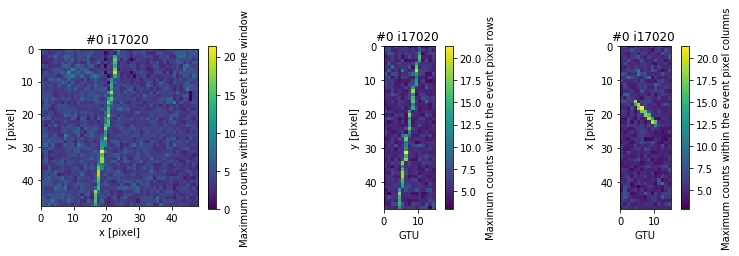

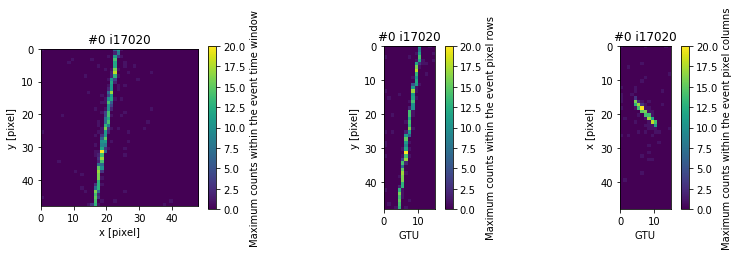

#1	(0)
	event_id: 17029
	packet_id: 1
	gtu_in_packet: 33
	num_gtu: 17
	num_frames_signals_ge_bg: 11.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h04m43s/simu2npy/ev_9_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


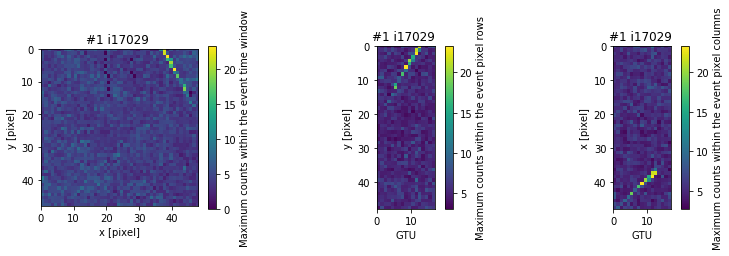

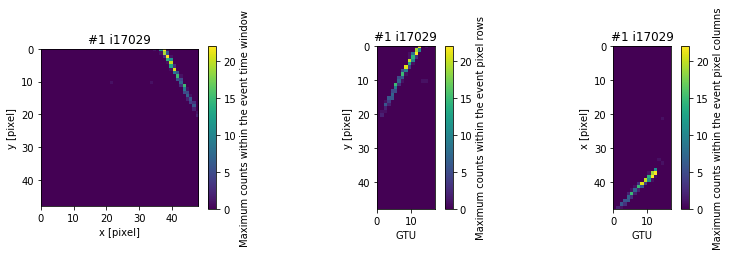

#2	(0)
	event_id: 17041
	packet_id: 1
	gtu_in_packet: 34
	num_gtu: 16
	num_frames_signals_ge_bg: 7.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h04m43s/simu2npy/ev_9_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


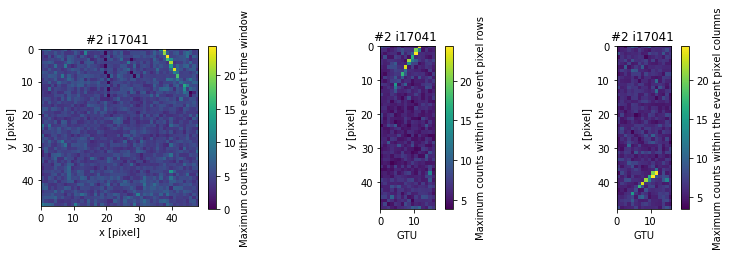

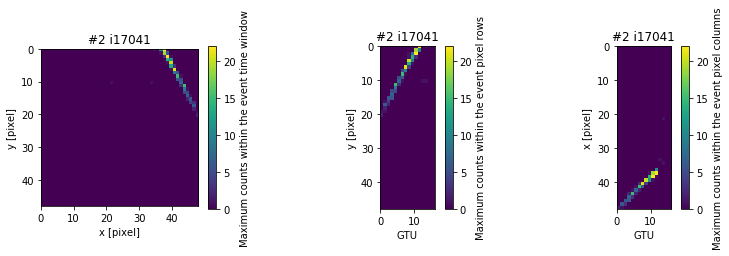

#3	(0)
	event_id: 17050
	packet_id: 1
	gtu_in_packet: 34
	num_gtu: 21
	num_frames_signals_ge_bg: 14.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h04m43s/simu2npy/ev_40_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


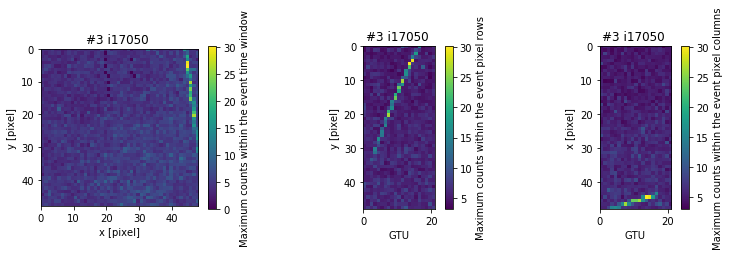

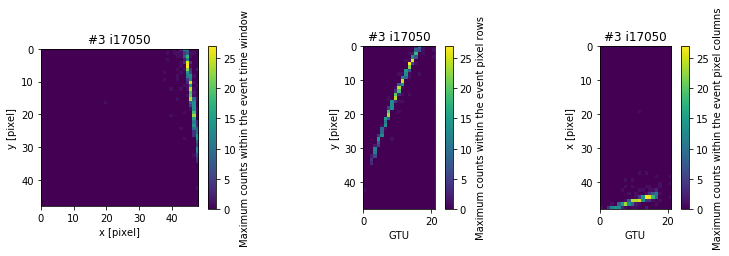

#4	(0)
	event_id: 17065
	packet_id: 1
	gtu_in_packet: 36
	num_gtu: 15
	num_frames_signals_ge_bg: 7.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-17h51m13s/simu2npy/ev_79_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


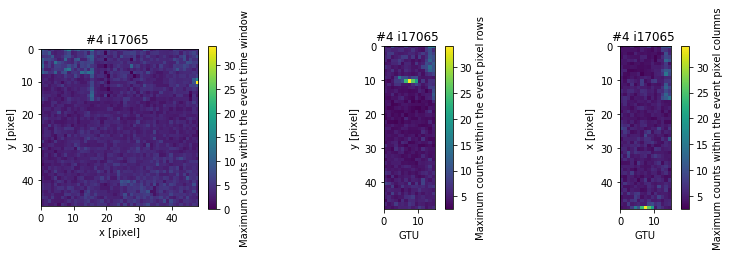

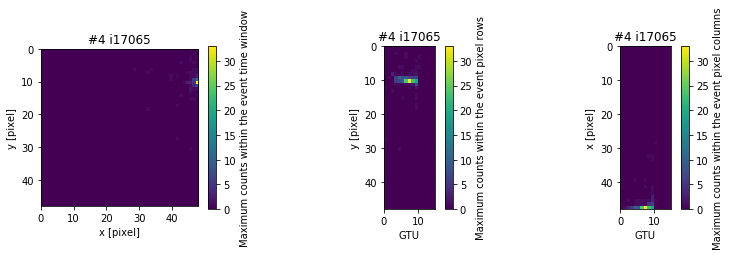

#5	(0)
	event_id: 17120
	packet_id: 1
	gtu_in_packet: 32
	num_gtu: 11
	num_frames_signals_ge_bg: 4.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_3.16e+12/thousnd27E10.2017-07-25-01h36m07s/simu2npy/ev_14_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


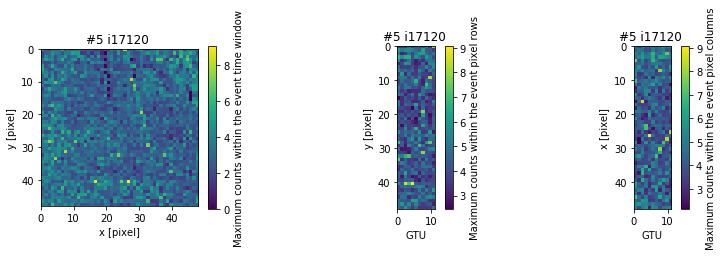

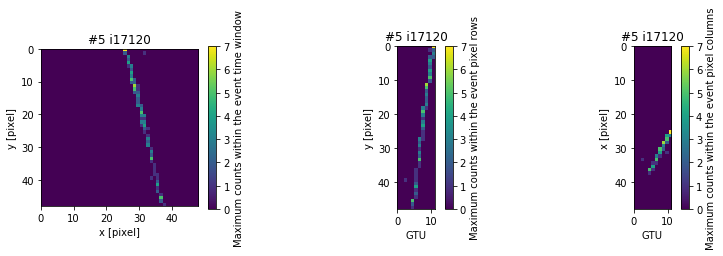

#6	(0)
	event_id: 17124
	packet_id: 1
	gtu_in_packet: 42
	num_gtu: 19
	num_frames_signals_ge_bg: 8.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-17h51m13s/simu2npy/ev_80_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


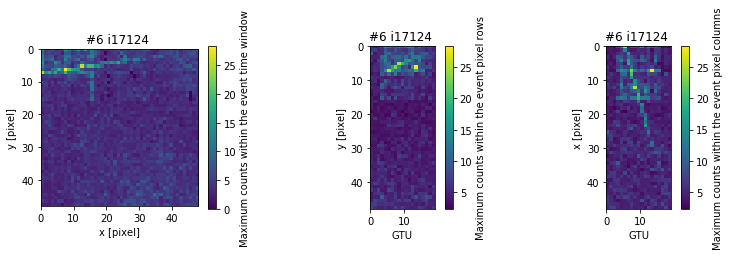

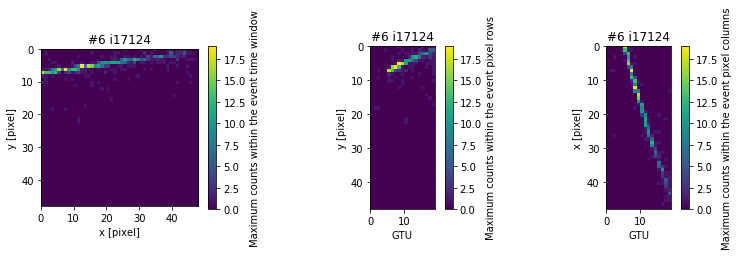

#7	(0)
	event_id: 17185
	packet_id: 1
	gtu_in_packet: 40
	num_gtu: 14
	num_frames_signals_ge_bg: 5.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_3.16e+12/thousnd27E10.2017-07-25-01h18m50s/simu2npy/ev_66_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


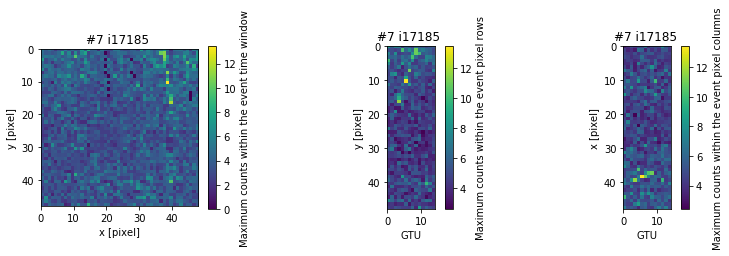

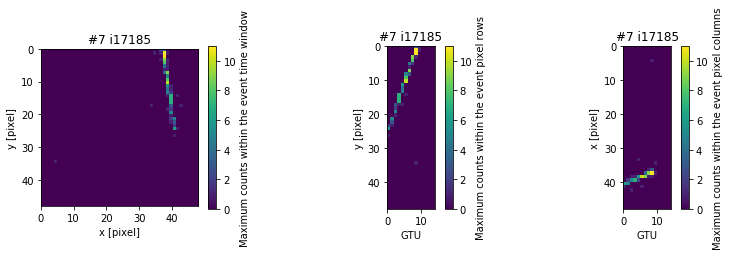

#8	(0)
	event_id: 17204
	packet_id: 1
	gtu_in_packet: 37
	num_gtu: 11
	num_frames_signals_ge_bg: 3.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_3.55e+12/thousnd27E11.2017-07-25-01h54m01s/simu2npy/ev_8_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


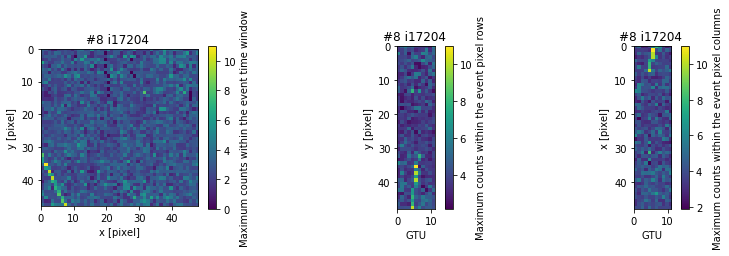

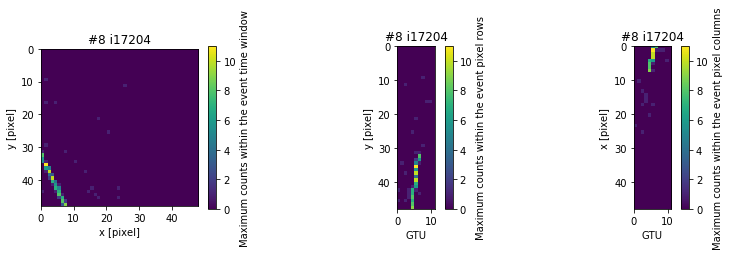

#9	(0)
	event_id: 17219
	packet_id: 1
	gtu_in_packet: 50
	num_gtu: 12
	num_frames_signals_ge_bg: 5.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h41m01s/simu2npy/ev_5_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


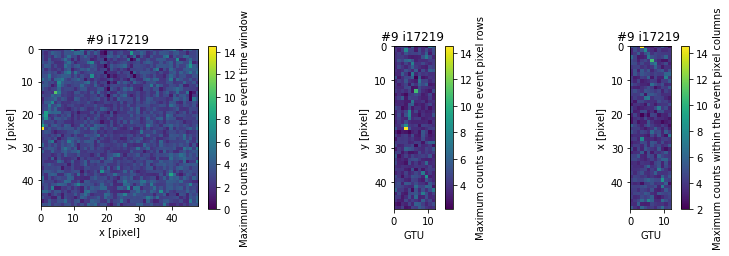

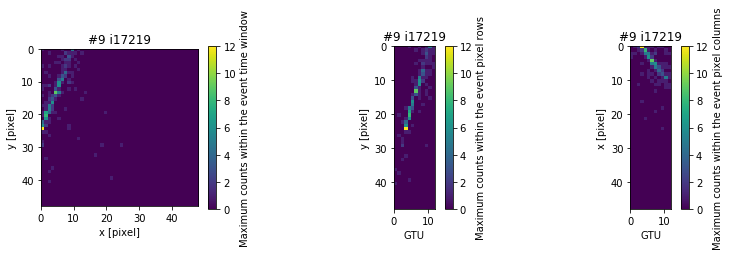

#10	(0)
	event_id: 17224
	packet_id: 1
	gtu_in_packet: 34
	num_gtu: 21
	num_frames_signals_ge_bg: 15.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_3.55e+12/thousnd27E11.2017-07-25-01h54m01s/simu2npy/ev_13_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


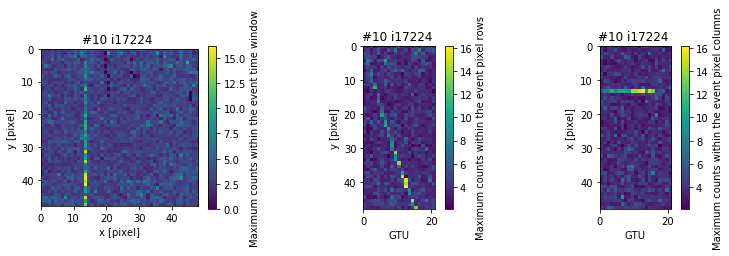

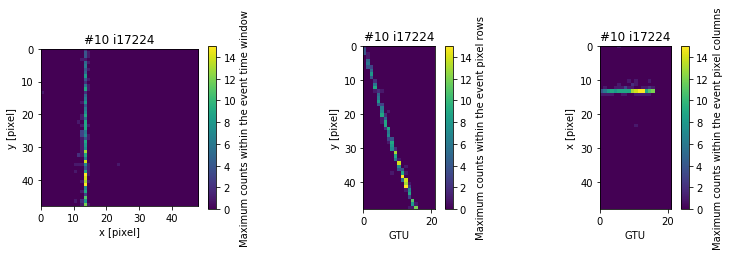

#11	(0)
	event_id: 17252
	packet_id: 1
	gtu_in_packet: 39
	num_gtu: 13
	num_frames_signals_ge_bg: 7.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_3.16e+12/thousnd27E10.2017-07-25-01h27m20s/simu2npy/ev_20_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


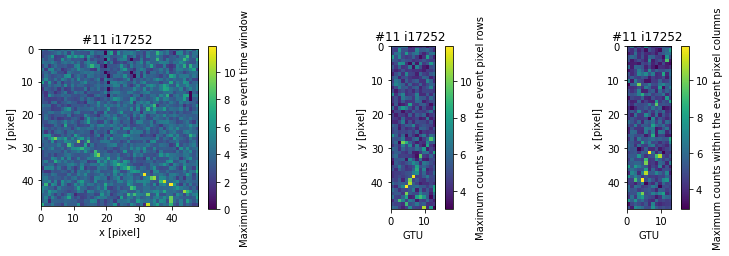

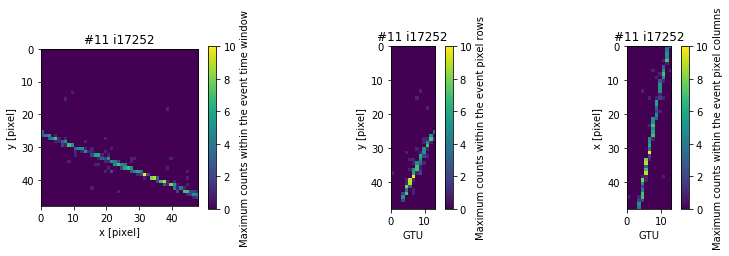

#12	(0)
	event_id: 17266
	packet_id: 1
	gtu_in_packet: 34
	num_gtu: 22
	num_frames_signals_ge_bg: 14.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h04m43s/simu2npy/ev_40_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


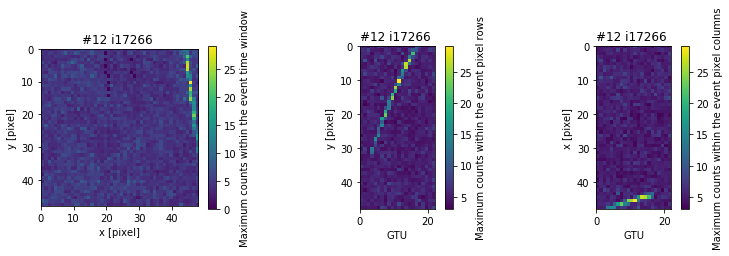

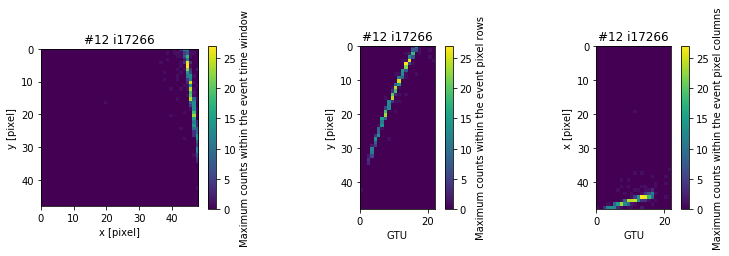

#13	(0)
	event_id: 17268
	packet_id: 1
	gtu_in_packet: 36
	num_gtu: 20
	num_frames_signals_ge_bg: 10.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_3.16e+12/thousnd27E10.2017-07-25-01h36m07s/simu2npy/ev_47_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


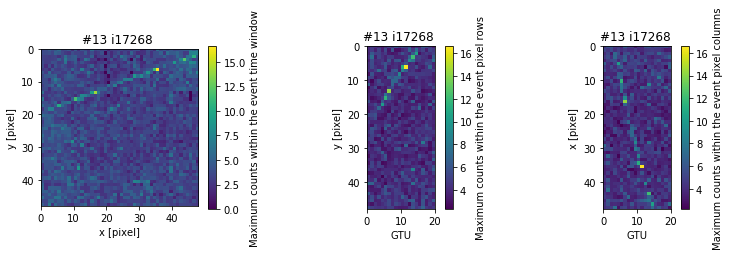

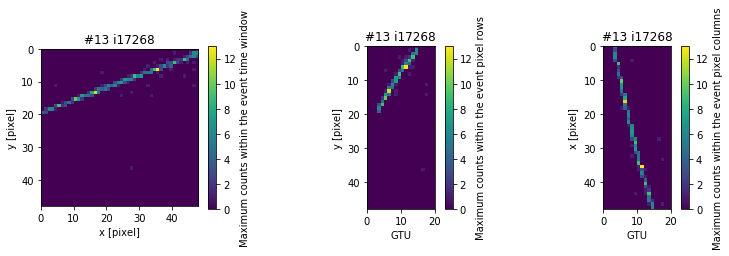

#14	(0)
	event_id: 17303
	packet_id: 1
	gtu_in_packet: 31
	num_gtu: 23
	num_frames_signals_ge_bg: 16.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h04m43s/simu2npy/ev_69_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


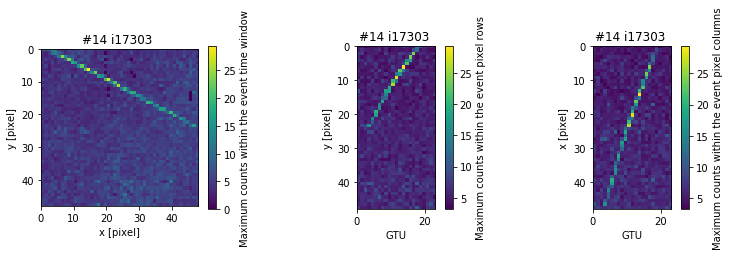

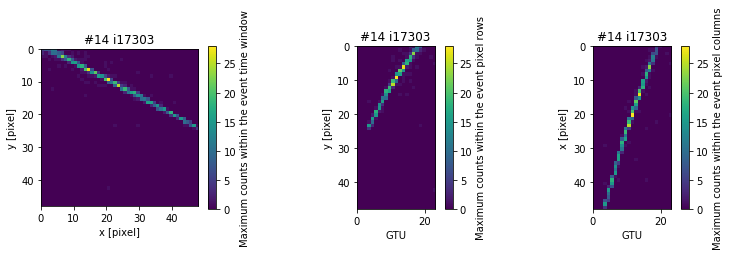

#15	(0)
	event_id: 17307
	packet_id: 1
	gtu_in_packet: 37
	num_gtu: 12
	num_frames_signals_ge_bg: 4.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h41m01s/simu2npy/ev_19_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


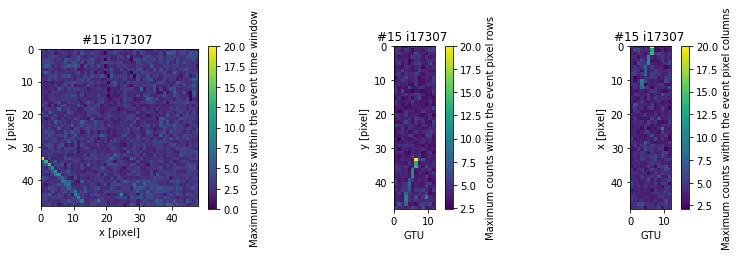

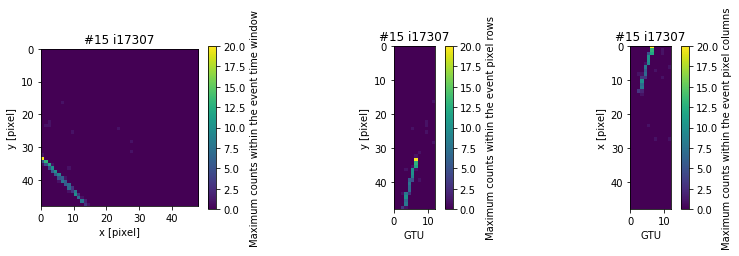

#16	(0)
	event_id: 17348
	packet_id: 1
	gtu_in_packet: 38
	num_gtu: 24
	num_frames_signals_ge_bg: 16.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h41m01s/simu2npy/ev_21_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


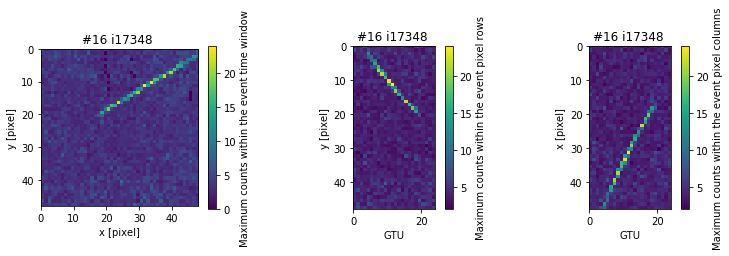

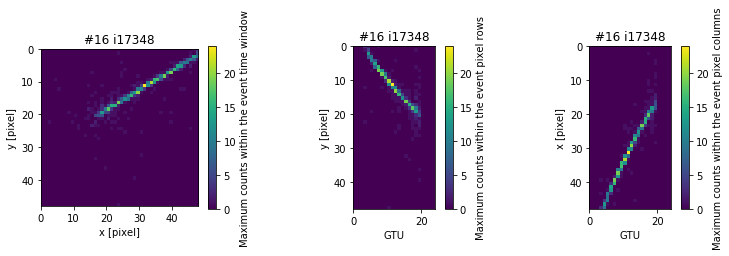

#17	(0)
	event_id: 17402
	packet_id: 1
	gtu_in_packet: 45
	num_gtu: 17
	num_frames_signals_ge_bg: 9.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h04m43s/simu2npy/ev_75_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


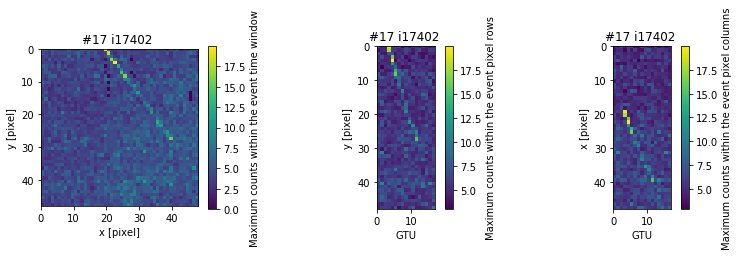

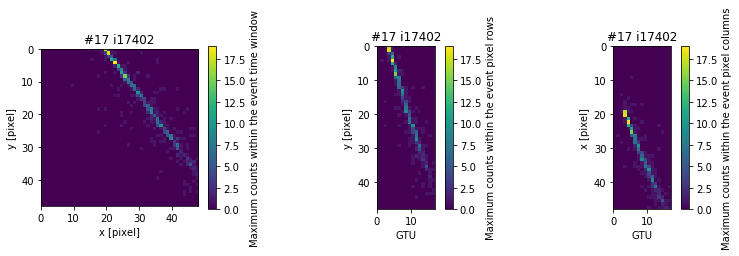

#18	(0)
	event_id: 17423
	packet_id: 1
	gtu_in_packet: 39
	num_gtu: 17
	num_frames_signals_ge_bg: 10.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_3.55e+12/thousnd27E11.2017-07-25-01h54m01s/simu2npy/ev_65_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


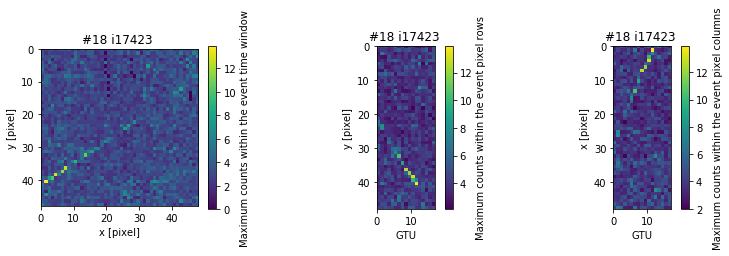

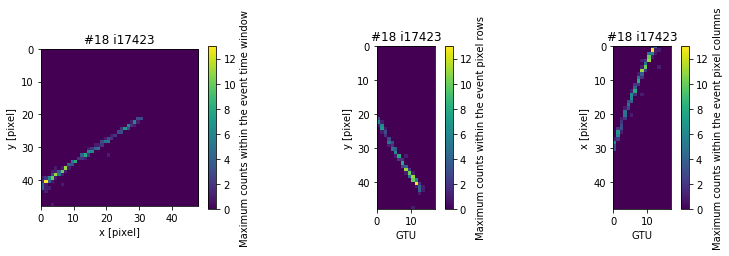

#19	(0)
	event_id: 17434
	packet_id: 1
	gtu_in_packet: 38
	num_gtu: 15
	num_frames_signals_ge_bg: 3.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-17h51m13s/simu2npy/ev_98_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


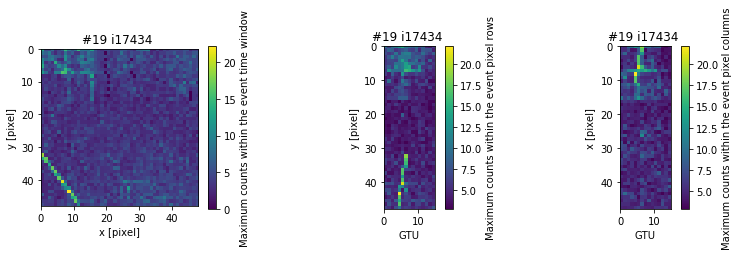

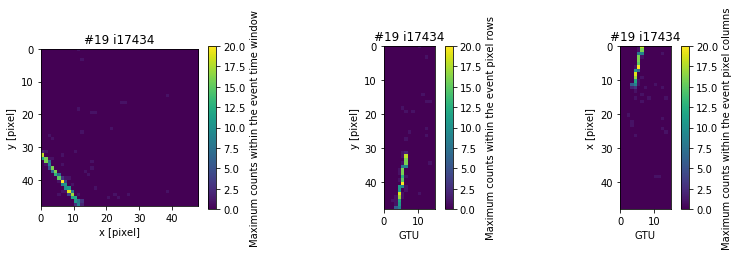

#20	(0)
	event_id: 17437
	packet_id: 1
	gtu_in_packet: 33
	num_gtu: 21
	num_frames_signals_ge_bg: 12.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h41m01s/simu2npy/ev_55_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


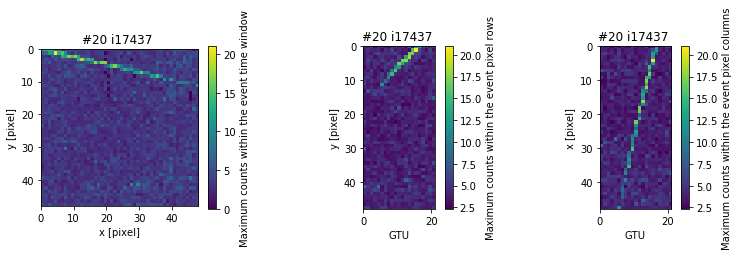

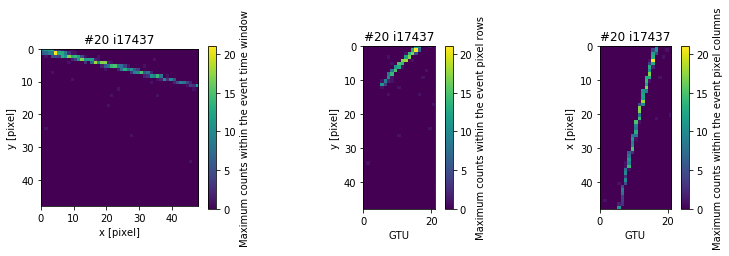

#21	(0)
	event_id: 17498
	packet_id: 1
	gtu_in_packet: 41
	num_gtu: 14
	num_frames_signals_ge_bg: 5.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_3.16e+12/thousnd27E10.2017-07-25-01h36m07s/simu2npy/ev_83_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


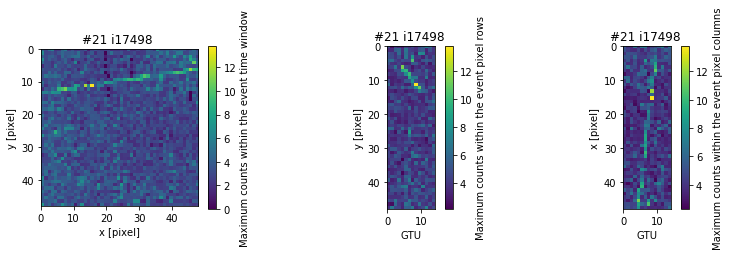

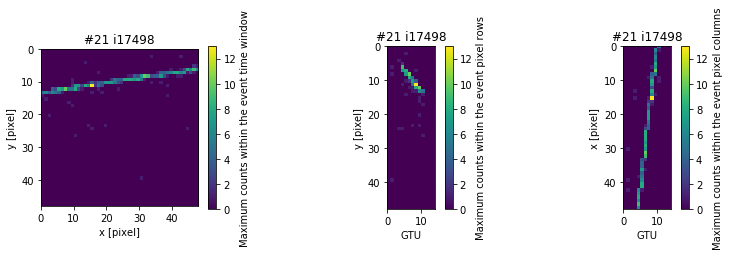

#22	(0)
	event_id: 17513
	packet_id: 1
	gtu_in_packet: 42
	num_gtu: 9
	num_frames_signals_ge_bg: 4.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_3.55e+12/thousnd27E11.2017-07-25-01h54m01s/simu2npy/ev_86_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


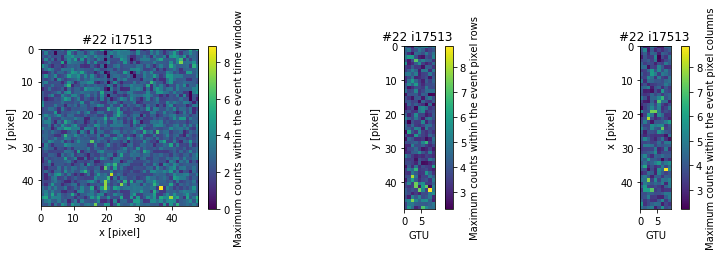

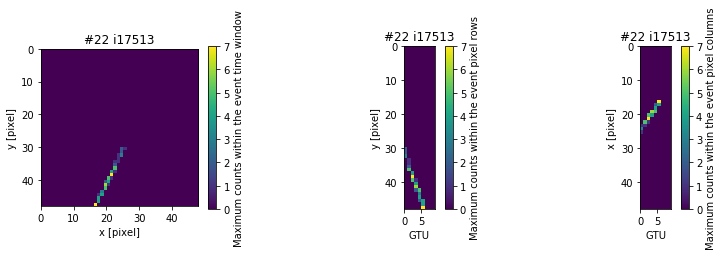

#23	(0)
	event_id: 17518
	packet_id: 1
	gtu_in_packet: 36
	num_gtu: 22
	num_frames_signals_ge_bg: 15.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h41m01s/simu2npy/ev_66_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


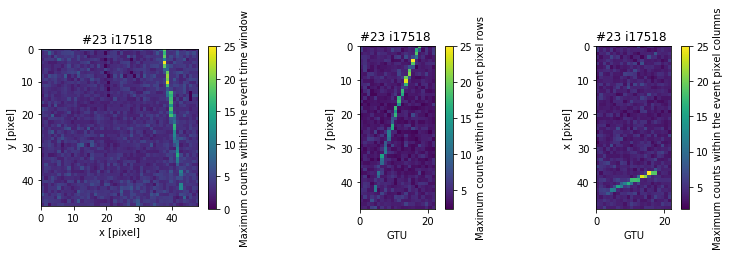

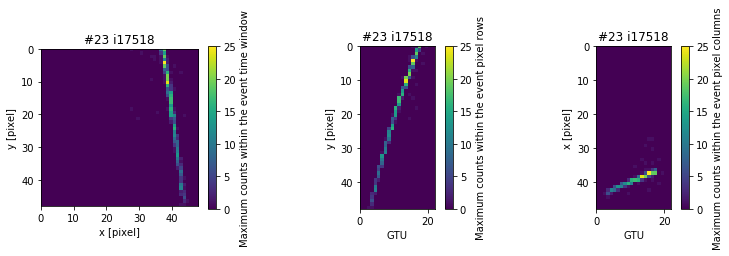

#24	(0)
	event_id: 17531
	packet_id: 1
	gtu_in_packet: 34
	num_gtu: 22
	num_frames_signals_ge_bg: 14.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h04m43s/simu2npy/ev_40_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


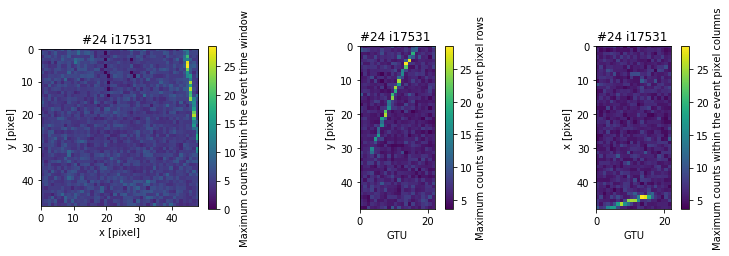

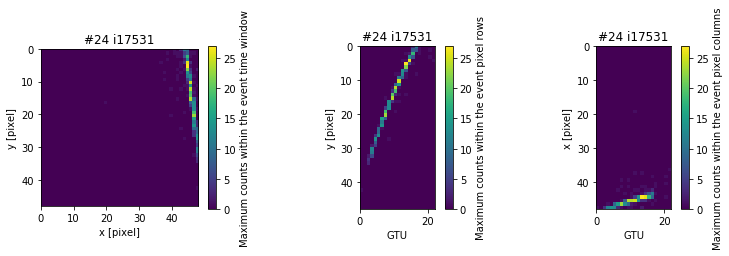

#25	(0)
	event_id: 17535
	packet_id: 1
	gtu_in_packet: 35
	num_gtu: 14
	num_frames_signals_ge_bg: 2.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_3.55e+12/thousnd27E11.2017-07-25-01h54m01s/simu2npy/ev_99_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


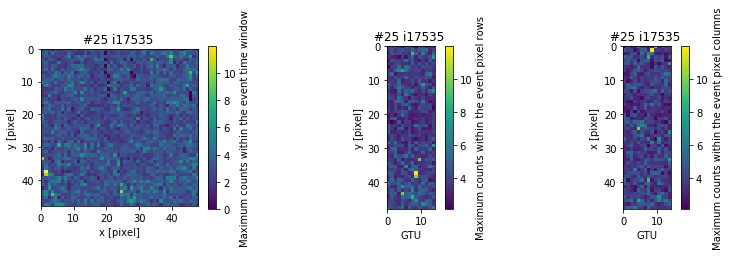

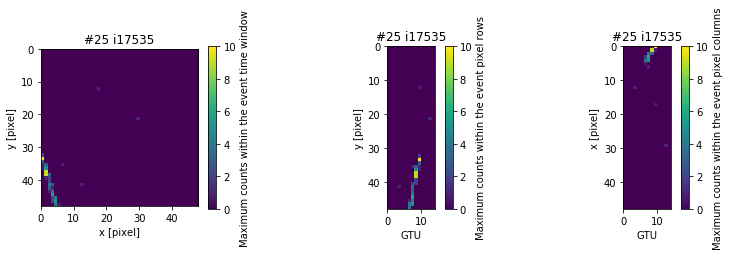

#26	(0)
	event_id: 17545
	packet_id: 1
	gtu_in_packet: 44
	num_gtu: 22
	num_frames_signals_ge_bg: 6.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_3.16e+12/thousnd27E10.2017-07-25-01h18m50s/simu2npy/ev_96_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


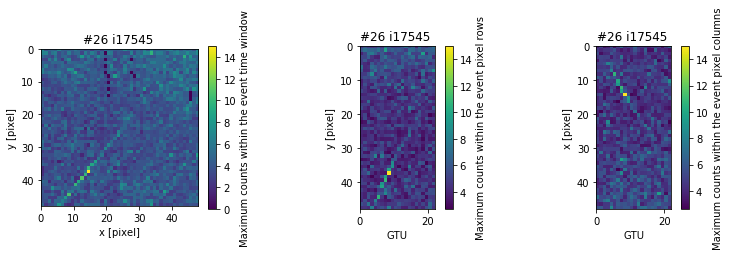

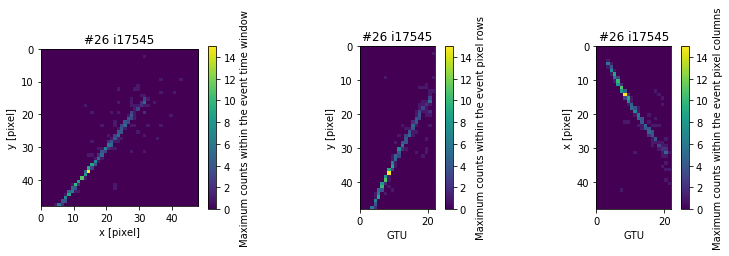

#27	(0)
	event_id: 17617
	packet_id: 1
	gtu_in_packet: 40
	num_gtu: 14
	num_frames_signals_ge_bg: 6.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h28m19s/simu2npy/ev_2_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


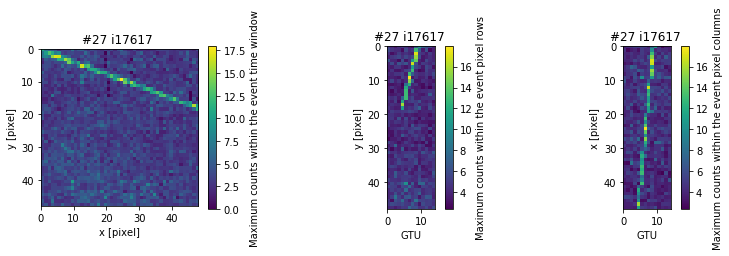

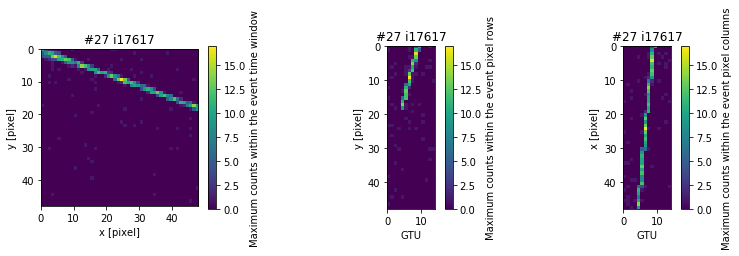

#28	(0)
	event_id: 17638
	packet_id: 1
	gtu_in_packet: 42
	num_gtu: 14
	num_frames_signals_ge_bg: 7.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h28m19s/simu2npy/ev_3_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


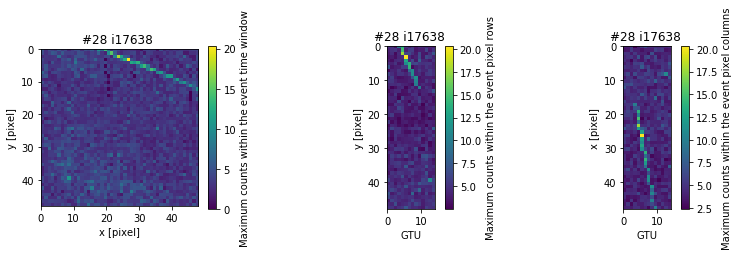

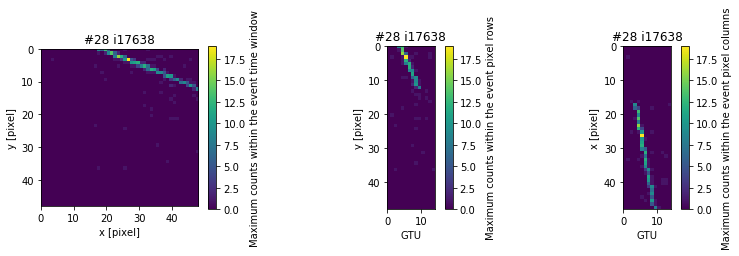

#29	(0)
	event_id: 17642
	packet_id: 1
	gtu_in_packet: 39
	num_gtu: 17
	num_frames_signals_ge_bg: 10.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_3.16e+12/thousnd27E10.2017-07-25-01h27m20s/simu2npy/ev_70_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


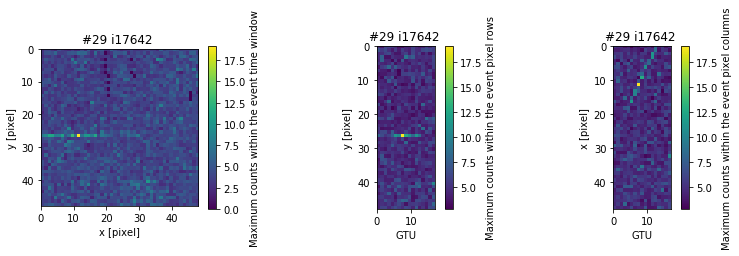

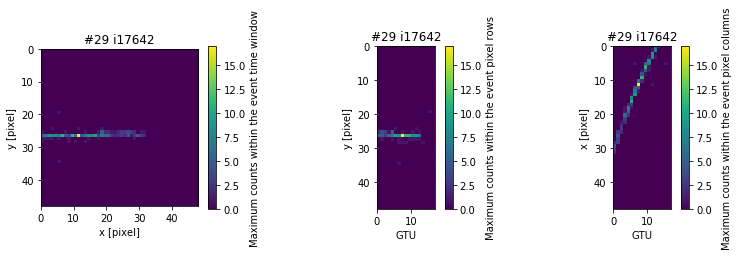

#30	(0)
	event_id: 17643
	packet_id: 1
	gtu_in_packet: 48
	num_gtu: 11
	num_frames_signals_ge_bg: 4.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h41m01s/simu2npy/ev_83_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


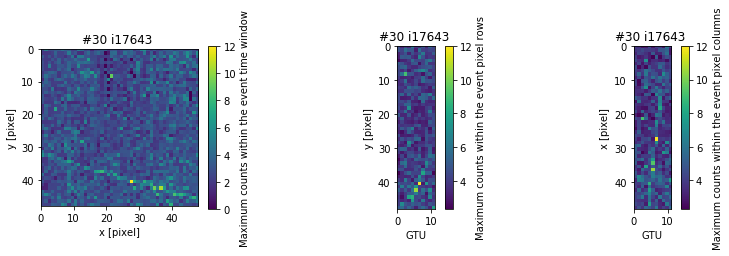

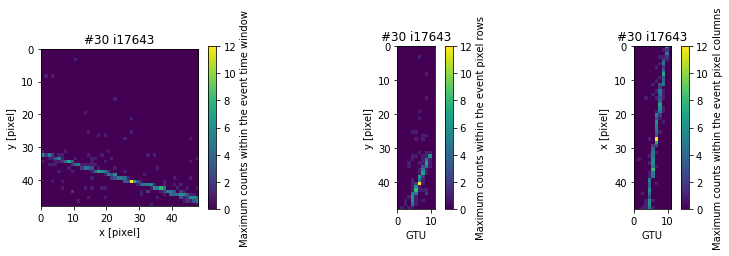

#31	(0)
	event_id: 17663
	packet_id: 1
	gtu_in_packet: 44
	num_gtu: 18
	num_frames_signals_ge_bg: 9.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h04m43s/simu2npy/ev_75_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


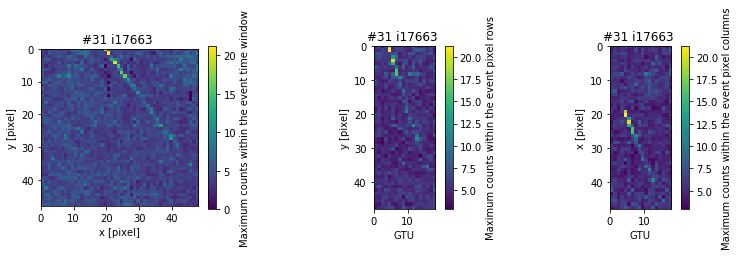

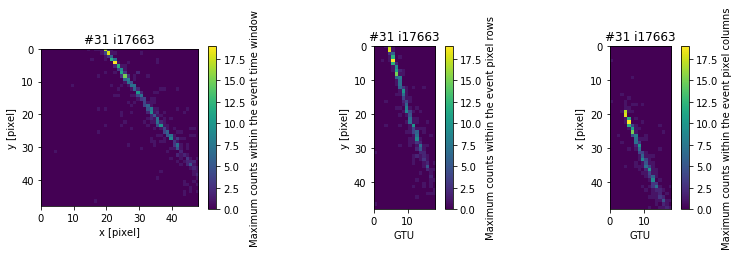

#32	(0)
	event_id: 17670
	packet_id: 1
	gtu_in_packet: 38
	num_gtu: 17
	num_frames_signals_ge_bg: 9.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h53m16s/simu2npy/ev_20_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


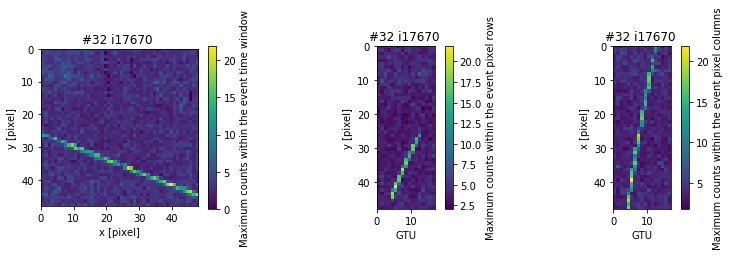

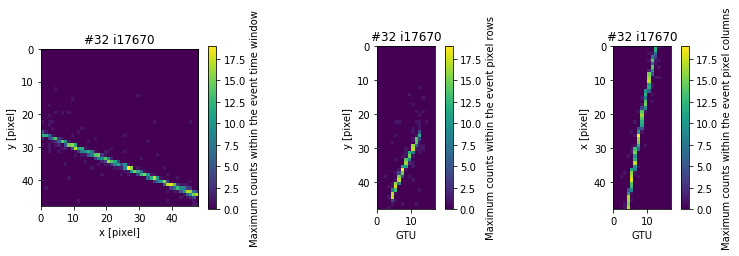

#33	(0)
	event_id: 17678
	packet_id: 1
	gtu_in_packet: 43
	num_gtu: 14
	num_frames_signals_ge_bg: 8.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h53m16s/simu2npy/ev_29_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


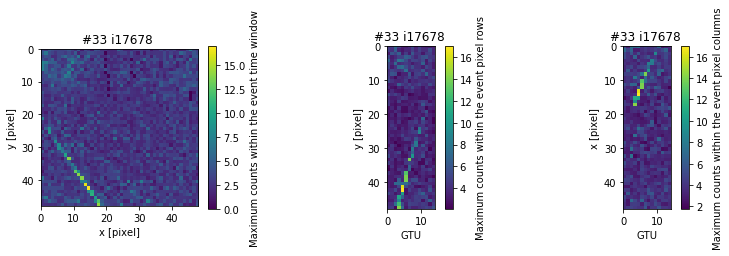

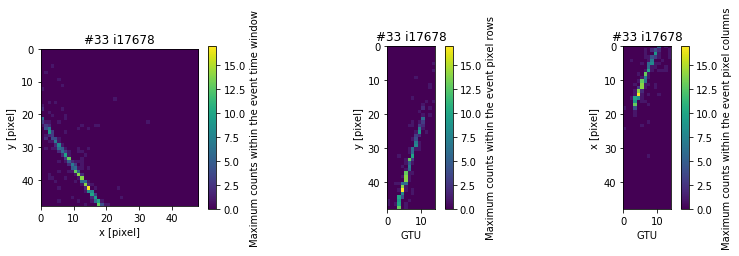

#34	(0)
	event_id: 17691
	packet_id: 1
	gtu_in_packet: 42
	num_gtu: 16
	num_frames_signals_ge_bg: 3.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h53m16s/simu2npy/ev_38_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


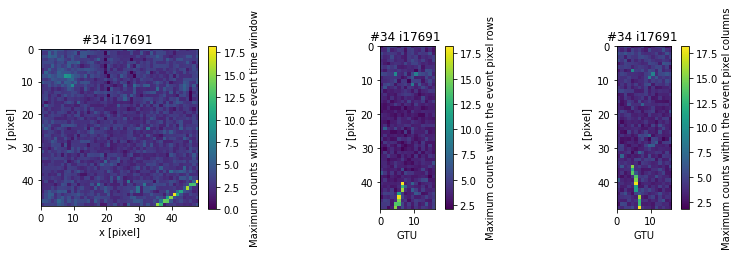

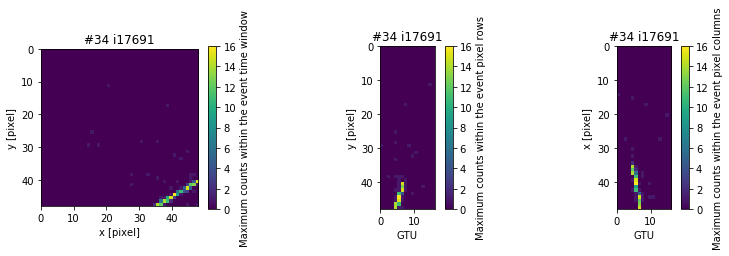

#35	(0)
	event_id: 17726
	packet_id: 1
	gtu_in_packet: 34
	num_gtu: 15
	num_frames_signals_ge_bg: 4.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h28m19s/simu2npy/ev_10_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


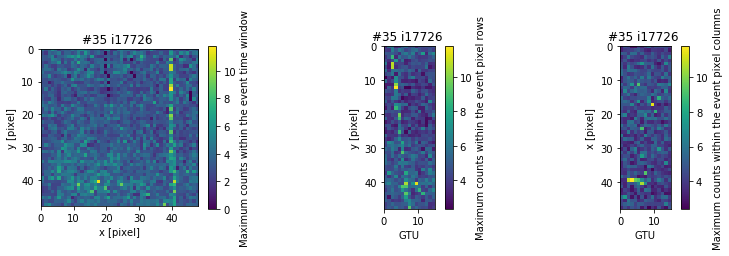

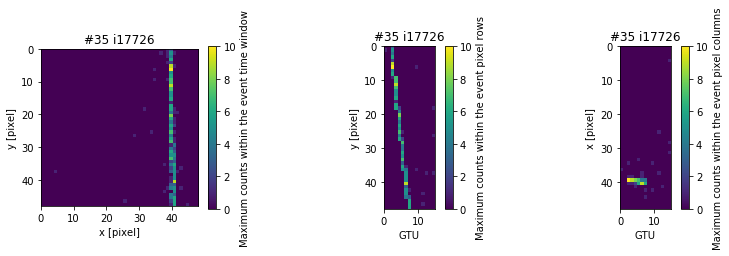

#36	(0)
	event_id: 17740
	packet_id: 1
	gtu_in_packet: 39
	num_gtu: 25
	num_frames_signals_ge_bg: 18.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h41m01s/simu2npy/ev_96_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


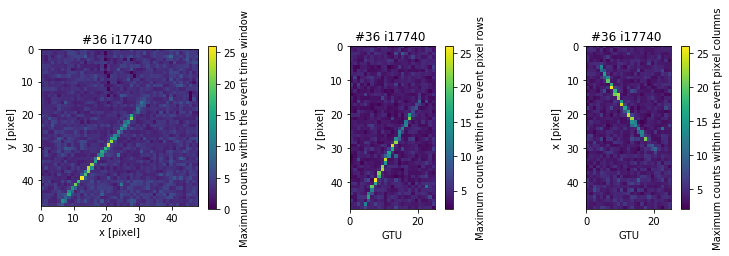

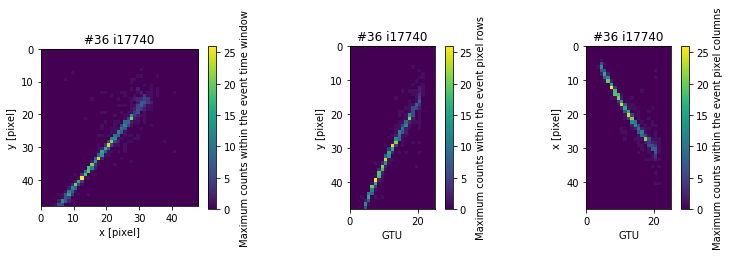

#37	(0)
	event_id: 17744
	packet_id: 1
	gtu_in_packet: 36
	num_gtu: 11
	num_frames_signals_ge_bg: 3.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_1.00e+13/thousnd27E20.2017-07-25-18h28m19s/simu2npy/ev_19_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


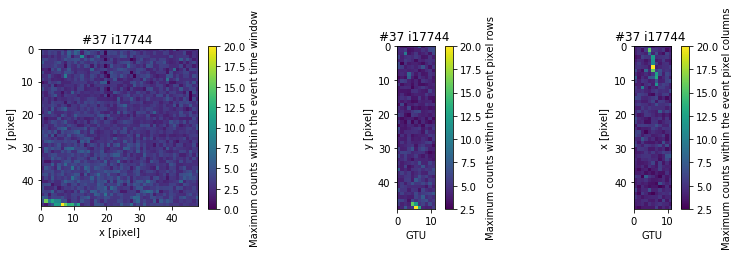

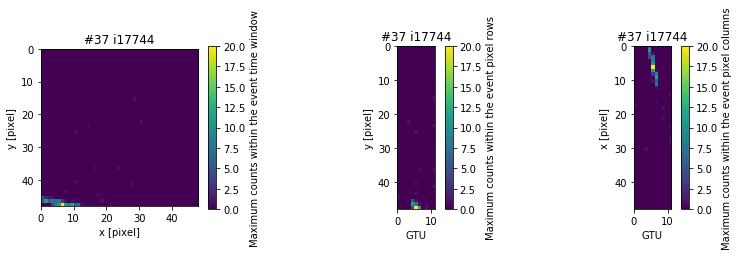

#38	(0)
	event_id: 17749
	packet_id: 1
	gtu_in_packet: 44
	num_gtu: 23
	num_frames_signals_ge_bg: 16.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_3.16e+12/thousnd27E10.2017-07-25-01h27m20s/simu2npy/ev_79_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


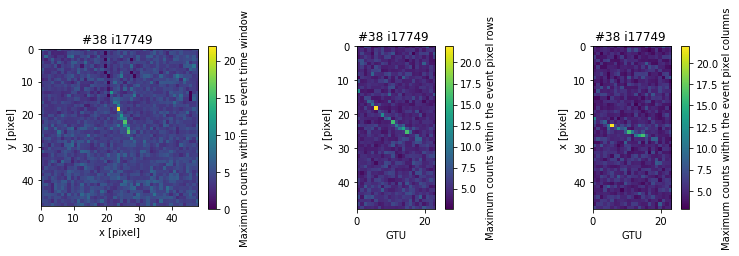

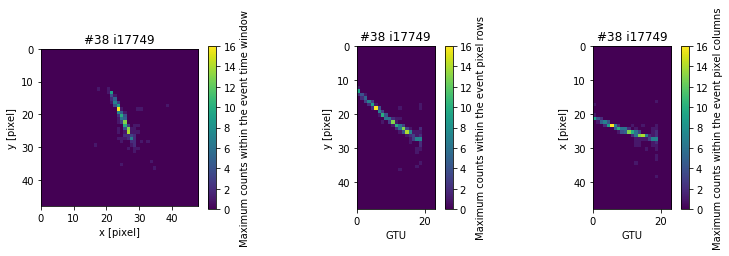

#39	(0)
	event_id: 17762
	packet_id: 1
	gtu_in_packet: 45
	num_gtu: 10
	num_frames_signals_ge_bg: 3.0
	simu2npy_signals_pathname_short: posz_27000000.00/energy_3.16e+12/thousnd27E10.2017-07-25-01h27m20s/simu2npy/ev_81_mc_1__signals.npy
	cond_selection_query: simu
	cond_selection_simple: track


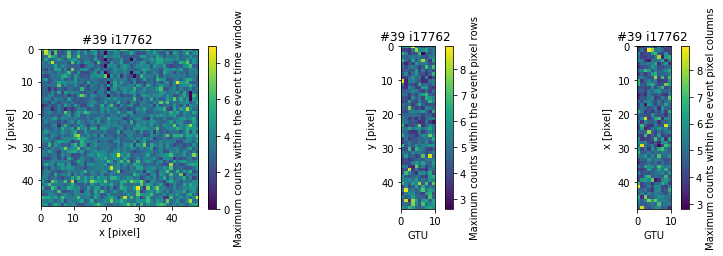

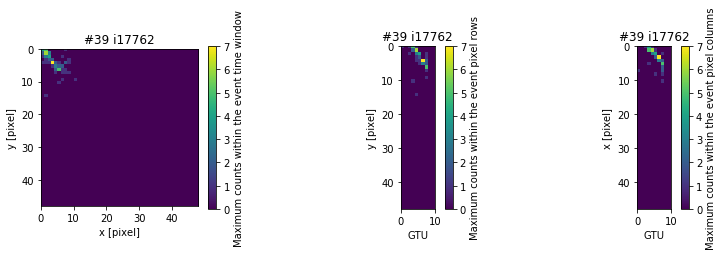

In [72]:
for label, events_to_vis_df in [
        ('simu_track', simu_track_df.iloc[300:340]), 
]:
    print('{} ({} entries)'.format(label, len(events_to_vis_df)))
    print('-' * 50)
    vis_events_df(
        events_to_vis_df, 
        events_per_figure=min(50, len(events_to_vis_df)), max_figures=1, vis_gtux=True, vis_gtuy=True, 
        close_after_vis=False, show=True, 
        additional_printed_columns=[
            'num_frames_signals_ge_bg', 'simu2npy_signals_pathname_short', 
            'cond_selection_query', 'cond_selection_simple'],
        by_one=True,
        extension_func=vis_simu_signal_with_original if label == 'track' else vis_simu_signal_default,
        single_proj_width=4, single_proj_height=3
    )
    print('=' * 50)

### Export of the datasets into tsv

Datasets are saved to be usable externally with different algorithms but reproducing these results.

In [65]:
overwrite_tsv_dump_files = False

In [66]:
# tsv_dump_dir = os.path.join(data_snippets_dir, 'events')
# os.makedirs(tsv_dump_dir, exist_ok=True)

# # labeled_flight_shower_tsv = os.path.join(tsv_dump_dir, 'labeled_flight_shower.tsv.gz')
# simu_track_tsv = os.path.join(tsv_dump_dir, 'simu_track.tsv.gz')
# labeled_flight_noise_tsv = os.path.join(tsv_dump_dir, 'labeled_flight_noise.tsv.gz')
# unlabeled_flight_noise_tsv = os.path.join(tsv_dump_dir, 'unlabeled_flight_noise.tsv.gz')

# simu_overflow_tsv = os.path.join(tsv_dump_dir, 'simu_overflow.tsv.gz')
# simu_noise_noise_tsv = os.path.join(tsv_dump_dir, 'simu_noise_noise.tsv.gz')
# simu_underflow_tsv = os.path.join(tsv_dump_dir, 'simu_underflow.tsv.gz')

# # print(labeled_flight_shower_tsv)
# print(simu_track_tsv)
# print(labeled_flight_noise_tsv)
# print(unlabeled_flight_noise_tsv)

# print(simu_overflow_tsv)
# print(simu_noise_noise_tsv)
# print(simu_underflow_tsv)

# # query_event_class_shower(flight_df_dict['lbl_noise_flight_df']).to_csv(labeled_flight_shower_tsv, sep='\t', compression='gzip')
# if overwrite_tsv_dump_files or not os.path.exists(simu_track_tsv):
#     query_simu_track(combined_simu_df).to_csv(simu_track_tsv, sep='\t', compression='gzip')
# if overwrite_tsv_dump_files or not os.path.exists(labeled_flight_noise_tsv):    
#     query_labeled_flight_noise(flight_df_dict['lbl_noise_flight_df']).to_csv(labeled_flight_noise_tsv, sep='\t', compression='gzip')
# if overwrite_tsv_dump_files or not os.path.exists(unlabeled_flight_noise_tsv):    
#     query_unlabeled_flight_noise(flight_df_dict['unl_noise_flight_df']).to_csv(unlabeled_flight_noise_tsv, sep='\t', compression='gzip')

# if overwrite_tsv_dump_files or not os.path.exists(simu_underflow_tsv):    
#     query_simu_underflow(combined_simu_df).to_csv(simu_underflow_tsv, sep='\t', compression='gzip')
# if overwrite_tsv_dump_files or not os.path.exists(simu_overflow_tsv):    
#     query_simu_overflow(combined_simu_df).to_csv(simu_overflow_tsv, sep='\t', compression='gzip')
# if overwrite_tsv_dump_files or not os.path.exists(simu_noise_noise_tsv):    
#     query_simu_noise_noise(combined_simu_df).to_csv(simu_noise_noise_tsv, sep='\t', compression='gzip')

ver4_machine_learning_w_labeled_flight_20190217/events/simu_track.tsv.gz
ver4_machine_learning_w_labeled_flight_20190217/events/labeled_flight_noise.tsv.gz
ver4_machine_learning_w_labeled_flight_20190217/events/unlabeled_flight_noise.tsv.gz
ver4_machine_learning_w_labeled_flight_20190217/events/simu_overflow.tsv.gz
ver4_machine_learning_w_labeled_flight_20190217/events/simu_noise_noise.tsv.gz
ver4_machine_learning_w_labeled_flight_20190217/events/simu_underflow.tsv.gz


#### Additional checks
(not in the report)

In [67]:
print(np.count_nonzero(combined_simu_df['num_frames_signals_ge_bg'] == combined_simu_df['num_frames_signals_gt_bg']))
print(np.count_nonzero(combined_simu_df['num_frames_signals_ge_bg'] != combined_simu_df['num_frames_signals_gt_bg']))

41071
123329


In [68]:
combined_simu_df[combined_simu_df['num_frames_signals_ge_bg'].isnull()][['event_id', 'cond_selection_combined', 'num_frames_counts_gt_bg']].head()

,event_id,cond_selection_combined,num_frames_counts_gt_bg
35607,11479,noise_noise_underflow,NaN
35608,11500,noise_noise_overflow,NaN
35609,11507,noise_noise_underflow,NaN
35610,11516,noise_noise_overflow,NaN
35611,11533,noise_noise_overflow,NaN


### Concatenated arrays (np.ndarray)
(not in the report)

Transformation of multiple `pandas.DataFrame` objects into concatenated `numpy.ndarray`. 
Following arrays are created:
- `learning_data__X` - training data for an algorithm - data
- `learning_data__y` - training data for an algorithm - labels
- `learning_data__event_id` - event id of the data in the dataset - important after `test_train_split()`, used to associate predictions with the original events
- `learning_data__source_class` - source class of the data in the dataset - important after `test_train_split()`, used to associate predictions with the original events, especially to be able to expres accuracy of predictions for a specific source class of data - e.g. label flight noise events

In [69]:
learning_data__X = np.concatenate([
    showers_nonan_w_event_id_df[analyzed_common_df_columns].values, 
    non_showers_nonan_w_event_id_df[analyzed_common_df_columns].values
])
learning_data__y = np.concatenate([
    np.ones(len(showers_nonan_w_event_id_df)), 
    np.zeros(len(non_showers_nonan_w_event_id_df))
])
learning_data__event_id = np.concatenate([
    showers_nonan_w_event_id_df['event_id'].values, 
    non_showers_nonan_w_event_id_df['event_id'].values
])
learning_data__source_class = np.concatenate([
#     np.ones(len(showers_nonan_w_event_id_df)),
    *[np.ones(len(shower_subset_df)) * shower_subset_class_numbers_dict[shower_subset_label] \
      for shower_subset_df, shower_subset_label in zip(shower_subsets_list, shower_subset_priority_order)],
    *[np.ones(len(non_shower_subset_df)) * noise_subset_class_numbers_dict[noise_subset_label] \
      for non_shower_subset_df, noise_subset_label in zip(non_shower_subsets_list, noise_subset_priority_order)]
])

### Labeled concatenated dataset (pd.DataFrame)
(not in the report)

In [70]:
labeled_data_nonan_w_event_id_w_cls_df = pd.concat([showers_nonan_w_event_id_df, non_showers_nonan_w_event_id_df])
labeled_data_nonan_w_event_id_w_cls_df['bin_class'] = learning_data__y
labeled_data_nonan_w_event_id_w_cls_df['class'] = learning_data__source_class

# noise_subset_class_numbers

In [71]:
labeled_data_nonan_w_event_id_w_cls_df['class'].unique()

array([ 1., -3., -2.,  0.])

In [72]:
labeled_data_nonan_w_event_id_w_cls_df.head()

,alt1_gtu_x_clusters_clu_areas_max,alt1_gtu_x_clusters_count,alt1_gtu_x_clusters_max_peak_clu_height,alt1_gtu_x_clusters_max_peak_clu_size,alt1_gtu_x_clusters_max_peak_clu_width,alt1_gtu_x_clusters_max_size_clu_height,alt1_gtu_x_clusters_max_size_clu_width,alt1_gtu_x_clusters_sizes_max,alt1_gtu_x_clusters_sizes_min,alt1_gtu_x_hough_peak_thr1_line_clusters_clu_areas_max,...,trg_x_y_hough_peak_thr3_line_clusters_max_size_clu_height,trg_x_y_hough_peak_thr3_line_clusters_max_size_clu_width,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_height,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_size,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr3_line_clusters_sizes_max,trg_x_y_hough_peak_thr3_major_line_phi,trg_x_y_hough_peak_thr3_major_line_rho,bin_class,class
0,423,1,47,29,9,47,9,29,29,108,...,25.0,21.0,25.0,19.0,21.0,19.0,2.743600,12.07390,1.0,1.0
1,400,2,15,24,22,15,22,24,14,100,...,4.0,4.0,4.0,8.0,4.0,8.0,0.017751,13.58780,1.0,1.0
2,528,1,48,51,11,48,11,51,51,81,...,16.0,12.0,16.0,14.0,12.0,14.0,2.808440,9.90164,1.0,1.0
3,517,1,47,43,11,47,11,43,43,93,...,11.0,8.0,11.0,9.0,8.0,9.0,2.731220,12.74620,1.0,1.0
4,480,1,48,131,10,48,10,131,131,510,...,100.0,82.0,100.0,49.0,82.0,49.0,5.894000,28.08540,1.0,1.0
